# Logit Diff Layer Sweep Analysis

Analyzing steering effects across Qwen3 models:
- **Dense**: 4B, 8B, 14B, 32B
- **MoE**: 30B-A3B (3B active), 235B-A22B (22B active)

For concepts: corrigible, self_awareness, sycophancy, coordinate_other_versions, survival_instinct, power_seeking_inclination.

**Methodology**: For each layer, we compute P("(A" | prompt) vs P("(B" | prompt) at the first generation position, measuring how steering shifts the model's latent disposition toward one answer.

**Note**: 235B-A22B is missing sycophancy data due to OOM (sycophancy prompts are 8x longer than other concepts).

In [74]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## Load All Data

In [75]:
import os
BASE_DIR = Path(os.path.expanduser("~/p/steering/results/logit_diff_sweep"))
print(f"Loading from: {BASE_DIR}")

MODELS = ["4B", "8B", "14B", "32B", "30B-A3B", "235B-A22B"]
CONCEPTS = ["corrigible", "self_awareness", "sycophancy", "coordinate_other_versions", "survival_instinct", "power_seeking_inclination"]

# Load all per-sample data
all_samples = []
all_summaries = []

for concept in CONCEPTS:
    for model in MODELS:
        # Handle different naming conventions
        model_dir_name = f"Qwen_Qwen3_{model.replace('-', '_')}"
        model_dir = BASE_DIR / concept / model_dir_name
        
        # Per-sample data
        sample_path = model_dir / "per_sample_all_layers.csv"
        if sample_path.exists():
            df = pd.read_csv(sample_path)
            all_samples.append(df)
        
        # Layer summary
        summary_path = model_dir / "layer_summary.csv"
        if summary_path.exists():
            df = pd.read_csv(summary_path)
            df["model"] = model
            df["concept"] = concept
            all_summaries.append(df)

if not all_samples:
    print("WARNING: No sample data found!")
    print(f"Checked paths like: {BASE_DIR / CONCEPTS[0] / 'Qwen_Qwen3_4B' / 'per_sample_all_layers.csv'}")
else:
    samples_df = pd.concat(all_samples, ignore_index=True)
    summaries_df = pd.concat(all_summaries, ignore_index=True)
    
    print(f"Loaded {len(samples_df):,} per-sample rows")
    print(f"Loaded {len(summaries_df)} layer summaries")
    print(f"\nModels: {sorted(samples_df['model'].unique())}")
    print(f"Concepts: {sorted(samples_df['concept'].unique())}")

Loading from: /home/omar-ayyub/p/steering/results/logit_diff_sweep
Loaded 297,324 per-sample rows
Loaded 1233 layer summaries

Models: ['14B', '235B-A22B', '30B-A3B', '32B', '4B', '8B']
Concepts: ['coordinate_other_versions', 'corrigible', 'power_seeking_inclination', 'self_awareness', 'survival_instinct', 'sycophancy']


## Summary Statistics

In [76]:
# Best layer per model/concept
best_layers = summaries_df.loc[summaries_df.groupby(["model", "concept"])["delta"].idxmax()]
best_layers = best_layers[["model", "concept", "layer", "delta", "baseline_mean", "positive_mean", "negative_mean"]]
best_layers = best_layers.sort_values(["concept", "model"])

print("Best Layer per Model/Concept (by max delta):")
print("="*80)
display(best_layers.round(3))

Best Layer per Model/Concept (by max delta):


,model,concept,layer,delta,baseline_mean,positive_mean,negative_mean
649,14B,coordinate_other_versions,27,5.280,-5.423,-2.337,-7.617
786,235B-A22B,coordinate_other_versions,79,3.816,-5.059,-2.757,-6.573
716,30B-A3B,coordinate_other_versions,26,5.295,-2.339,0.515,-4.780
692,32B,coordinate_other_versions,51,2.307,-2.561,-1.192,-3.499
596,4B,coordinate_other_versions,22,5.914,-3.013,0.115,-5.798
621,8B,coordinate_other_versions,22,3.545,-2.968,-0.544,-4.089
57,14B,corrigible,20,10.256,-0.682,8.912,-1.345
198,235B-A22B,corrigible,76,5.920,2.321,4.894,-1.026
131,30B-A3B,corrigible,26,13.874,-0.270,8.647,-5.227
100,32B,corrigible,44,4.482,1.011,5.521,1.039


In [77]:
# Pivot table of best deltas
pivot = best_layers.pivot(index="model", columns="concept", values="delta")
pivot = pivot.reindex(MODELS)

print("\nBest Delta by Model/Concept:")
print("="*60)
print("(Note: 235B-A22B missing sycophancy due to OOM)")
display(pivot.round(2))


Best Delta by Model/Concept:
(Note: 235B-A22B missing sycophancy due to OOM)


concept,coordinate_other_versions,corrigible,power_seeking_inclination,self_awareness,survival_instinct,sycophancy
model,,,,,,
4B,5.91,14.01,9.61,8.83,0.93,4.59
8B,3.55,7.78,3.12,8.82,0.96,1.49
14B,5.28,10.26,4.06,9.37,0.49,3.01
32B,2.31,4.48,2.78,2.29,0.92,2.11
30B-A3B,5.30,13.87,4.49,11.82,3.17,2.21
235B-A22B,3.82,5.92,7.21,5.37,5.25,NaN


## Layer-wise Delta Curves

How does steering effect (delta = positive - negative) vary across layers?

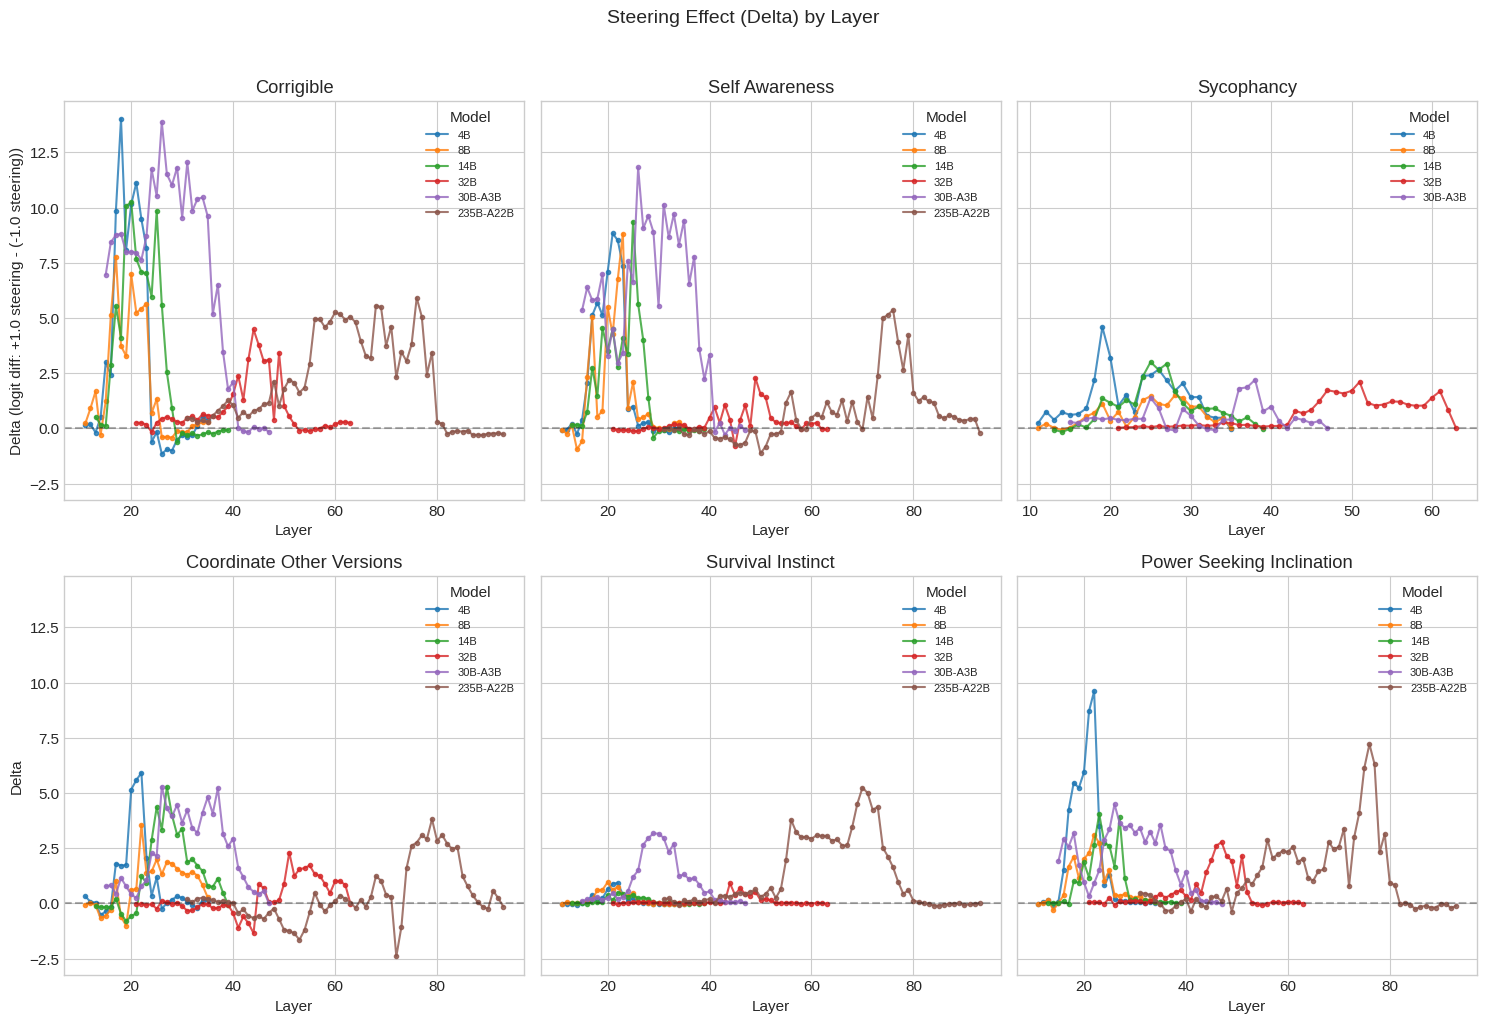

In [78]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for ax, concept in zip(axes, CONCEPTS):
    concept_data = summaries_df[summaries_df["concept"] == concept]
    
    for model in MODELS:
        model_data = concept_data[concept_data["model"] == model]
        if len(model_data) == 0:
            continue
        ax.plot(model_data["layer"], model_data["delta"], 
                marker="o", markersize=3, label=model, alpha=0.8)
    
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)
    ax.set_xlabel("Layer")
    ax.set_title(concept.replace("_", " ").title())
    ax.legend(title="Model", fontsize=8)

axes[0].set_ylabel("Delta (logit diff: +1.0 steering - (-1.0 steering))")
axes[3].set_ylabel("Delta")
plt.suptitle("Steering Effect (Delta) by Layer", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/layer_delta_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## Normalized Layer Curves

Normalize layer index to [0, 1] to compare across model sizes.

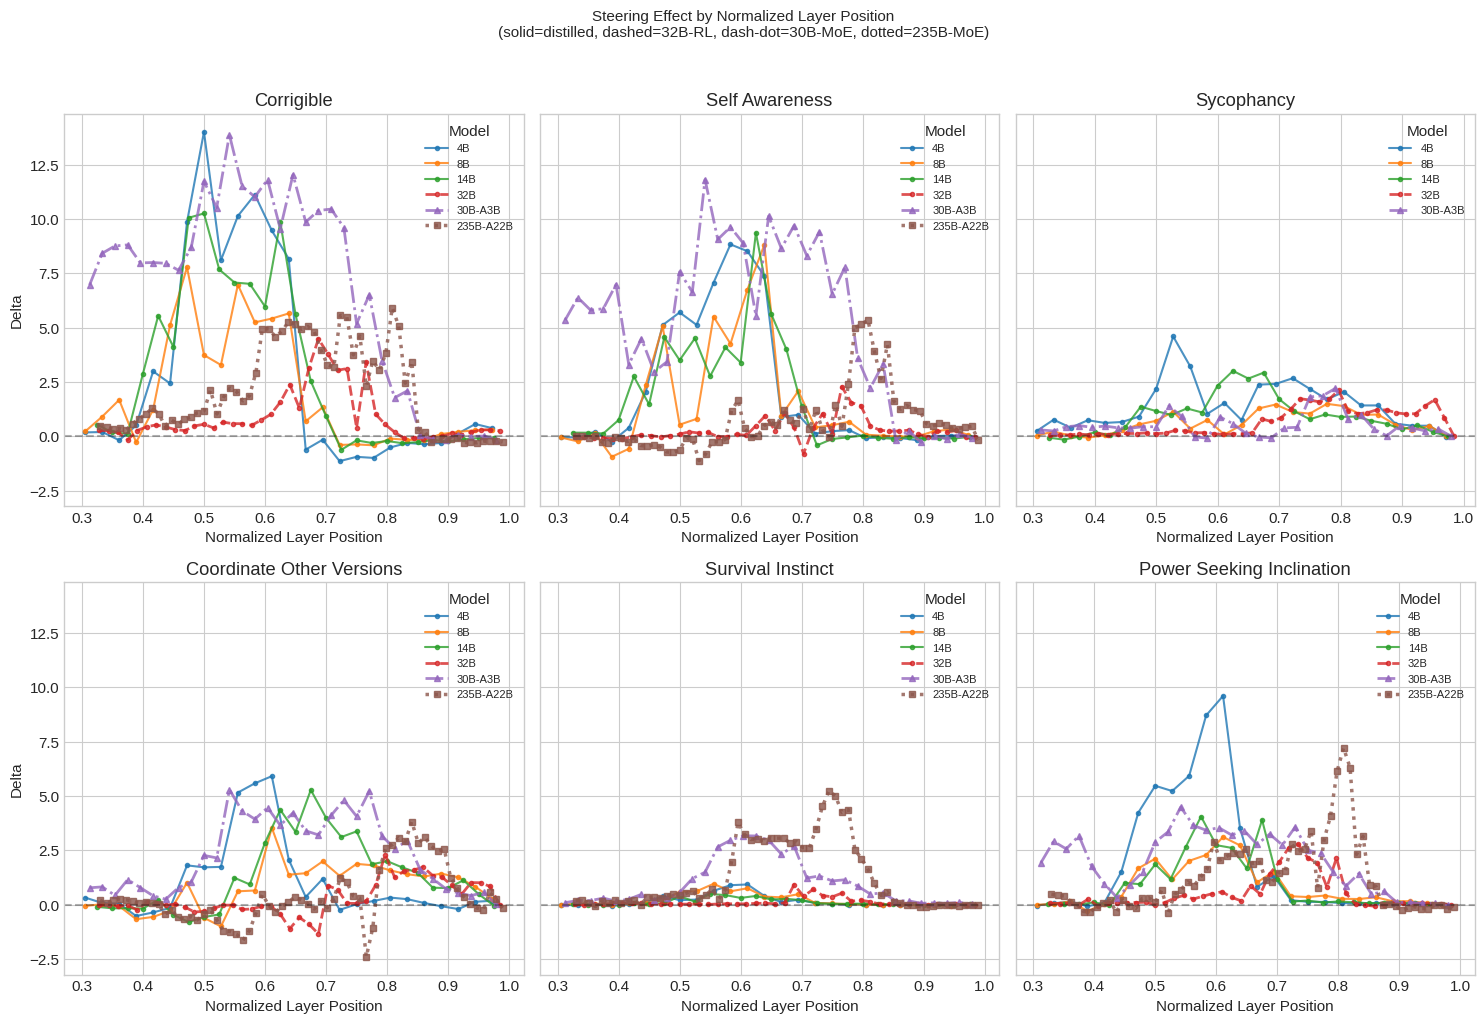

In [79]:
# Add normalized layer position (correct layer counts from Qwen3 configs)
LAYER_COUNTS = {"4B": 36, "8B": 36, "14B": 40, "32B": 64, "30B-A3B": 48, "235B-A22B": 94}

summaries_df["layer_frac"] = summaries_df.apply(
    lambda row: row["layer"] / LAYER_COUNTS[row["model"]], axis=1
)

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for ax, concept in zip(axes, CONCEPTS):
    concept_data = summaries_df[summaries_df["concept"] == concept]
    
    for model in MODELS:
        model_data = concept_data[concept_data["model"] == model]
        if len(model_data) == 0:
            continue
        # MoE models get distinct styles
        if "A22B" in model:
            style = {"linestyle": ":", "linewidth": 2.5, "marker": "s", "markersize": 4}
        elif "A3B" in model:
            style = {"linestyle": "-.", "linewidth": 2, "marker": "^", "markersize": 4}
        elif LAYER_COUNTS[model] == 64:
            style = {"linestyle": "--", "linewidth": 2, "marker": "o", "markersize": 3}
        else:
            style = {"linestyle": "-", "linewidth": 1.5, "marker": "o", "markersize": 3}
        ax.plot(model_data["layer_frac"], model_data["delta"], 
                label=model, alpha=0.8, **style)
    
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)
    ax.set_xlabel("Normalized Layer Position")
    ax.set_title(concept.replace("_", " ").title())
    ax.legend(title="Model", fontsize=8)

axes[0].set_ylabel("Delta")
axes[3].set_ylabel("Delta")
plt.suptitle("Steering Effect by Normalized Layer Position\n(solid=distilled, dashed=32B-RL, dash-dot=30B-MoE, dotted=235B-MoE)", fontsize=11, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/layer_delta_curves_normalized.png", dpi=150, bbox_inches="tight")
plt.show()

## Distribution of Logit Diffs at Best Layers

Violin plots showing per-sample logit diff distributions at the best layer for each model/concept.

In [80]:
# Get best layer for each model/concept
best_layer_map = best_layers.set_index(["model", "concept"])["layer"].to_dict()

# Filter samples to best layers only
samples_df["is_best_layer"] = samples_df.apply(
    lambda row: row["layer"] == best_layer_map.get((row["model"], row["concept"]), -1),
    axis=1
)
best_samples = samples_df[samples_df["is_best_layer"]].copy()

print(f"Samples at best layers: {len(best_samples):,}")

Samples at best layers: 8,484


/tmp/ipykernel_844675/3370356719.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
/tmp/ipykernel_844675/3370356719.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
/tmp/ipykernel_844675/3370356719.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

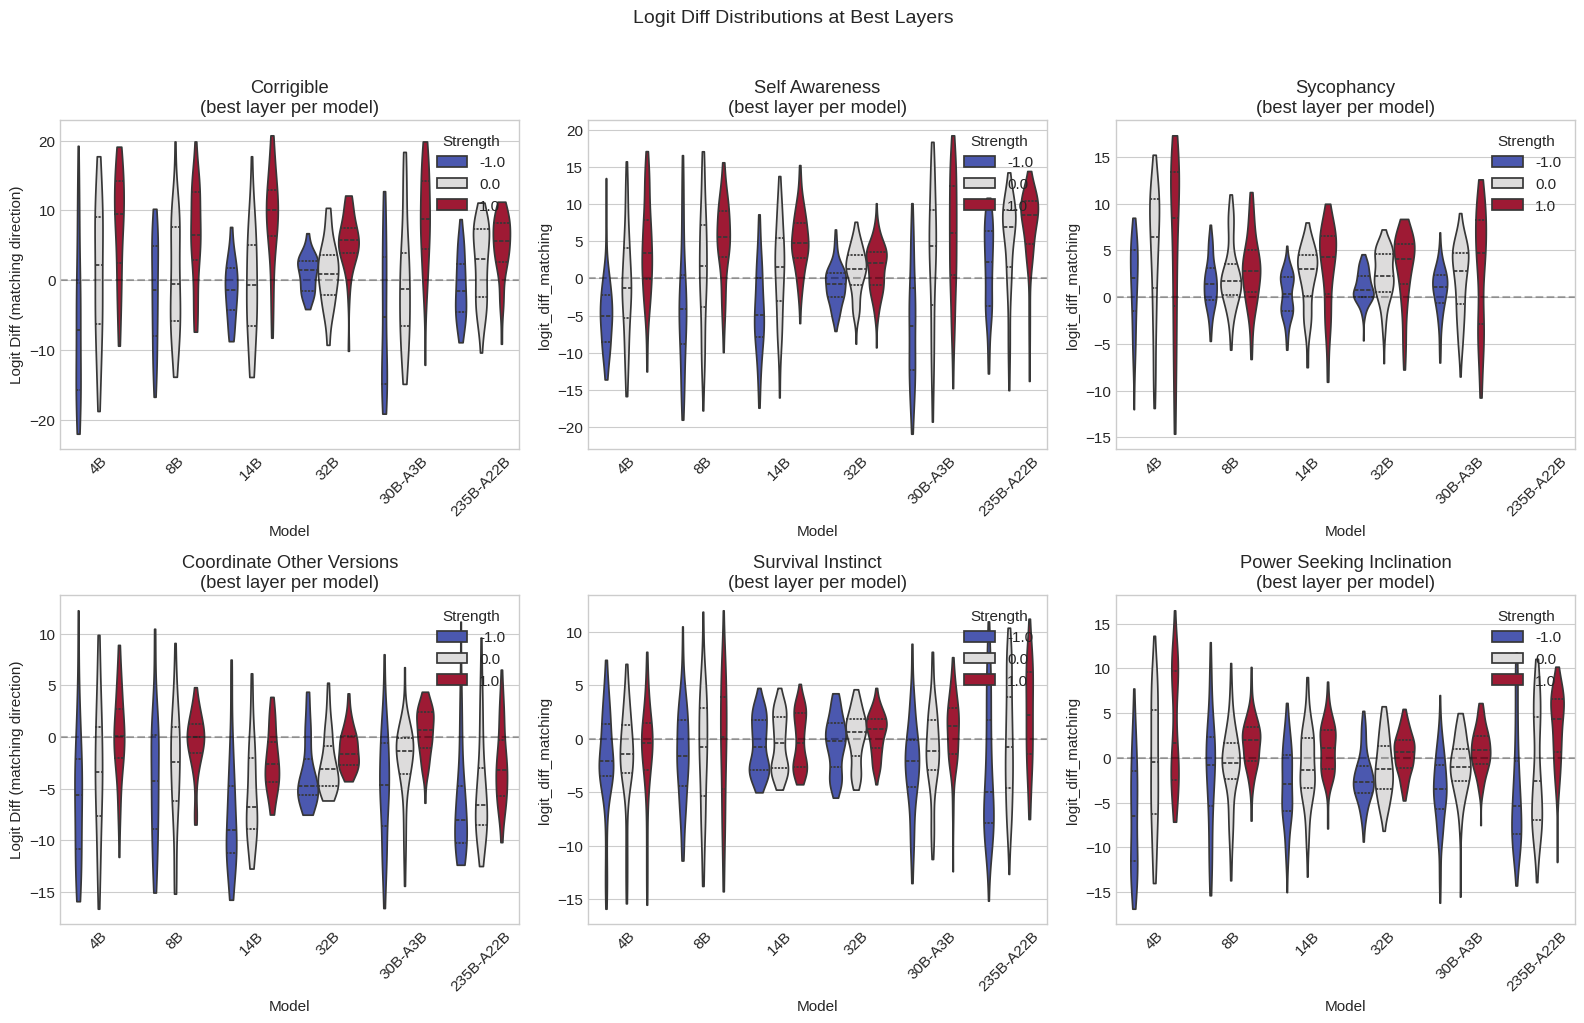

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for ax, concept in zip(axes, CONCEPTS):
    data = best_samples[best_samples["concept"] == concept]
    
    # Order models
    data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
    
    if len(data) > 0:
        sns.violinplot(
            data=data, x="model", y="logit_diff_matching", hue="strength",
            ax=ax, palette="coolwarm", inner="quartile", cut=0
        )
    
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)
    ax.set_xlabel("Model")
    ax.set_title(f"{concept.replace('_', ' ').title()}\n(best layer per model)")
    ax.legend(title="Strength", loc="upper right")
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel("Logit Diff (matching direction)")
axes[3].set_ylabel("Logit Diff (matching direction)")
plt.suptitle("Logit Diff Distributions at Best Layers", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/best_layer_violins.png", dpi=150, bbox_inches="tight")
plt.show()

## Heatmaps: Mean Logit Diff by Strength and Layer

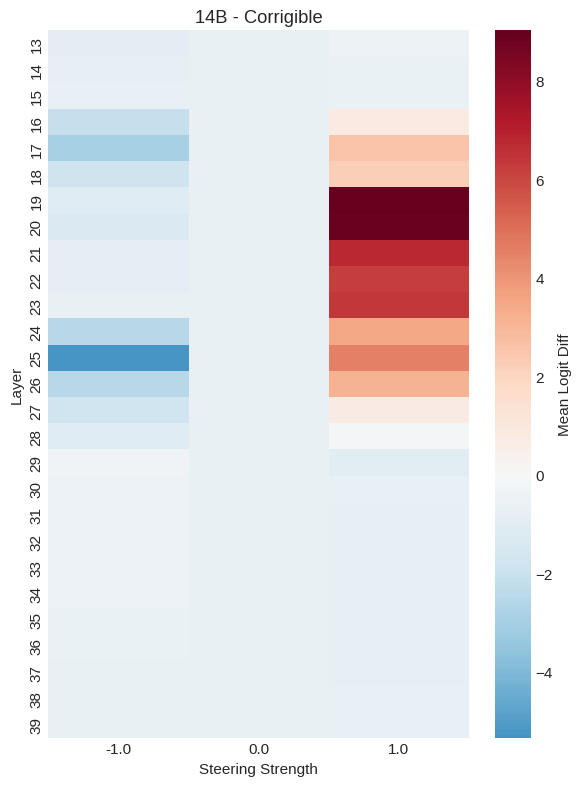

In [82]:
def plot_heatmap(model, concept):
    data = samples_df[(samples_df["model"] == model) & (samples_df["concept"] == concept)]
    
    pivot = data.pivot_table(
        index="layer", columns="strength", values="logit_diff_matching", aggfunc="mean"
    )
    
    fig, ax = plt.subplots(figsize=(6, 8))
    sns.heatmap(pivot, cmap="RdBu_r", center=0, ax=ax, cbar_kws={"label": "Mean Logit Diff"})
    ax.set_title(f"{model} - {concept.replace('_', ' ').title()}")
    ax.set_ylabel("Layer")
    ax.set_xlabel("Steering Strength")
    plt.tight_layout()
    return fig

# Show one example
fig = plot_heatmap("14B", "corrigible")
plt.show()

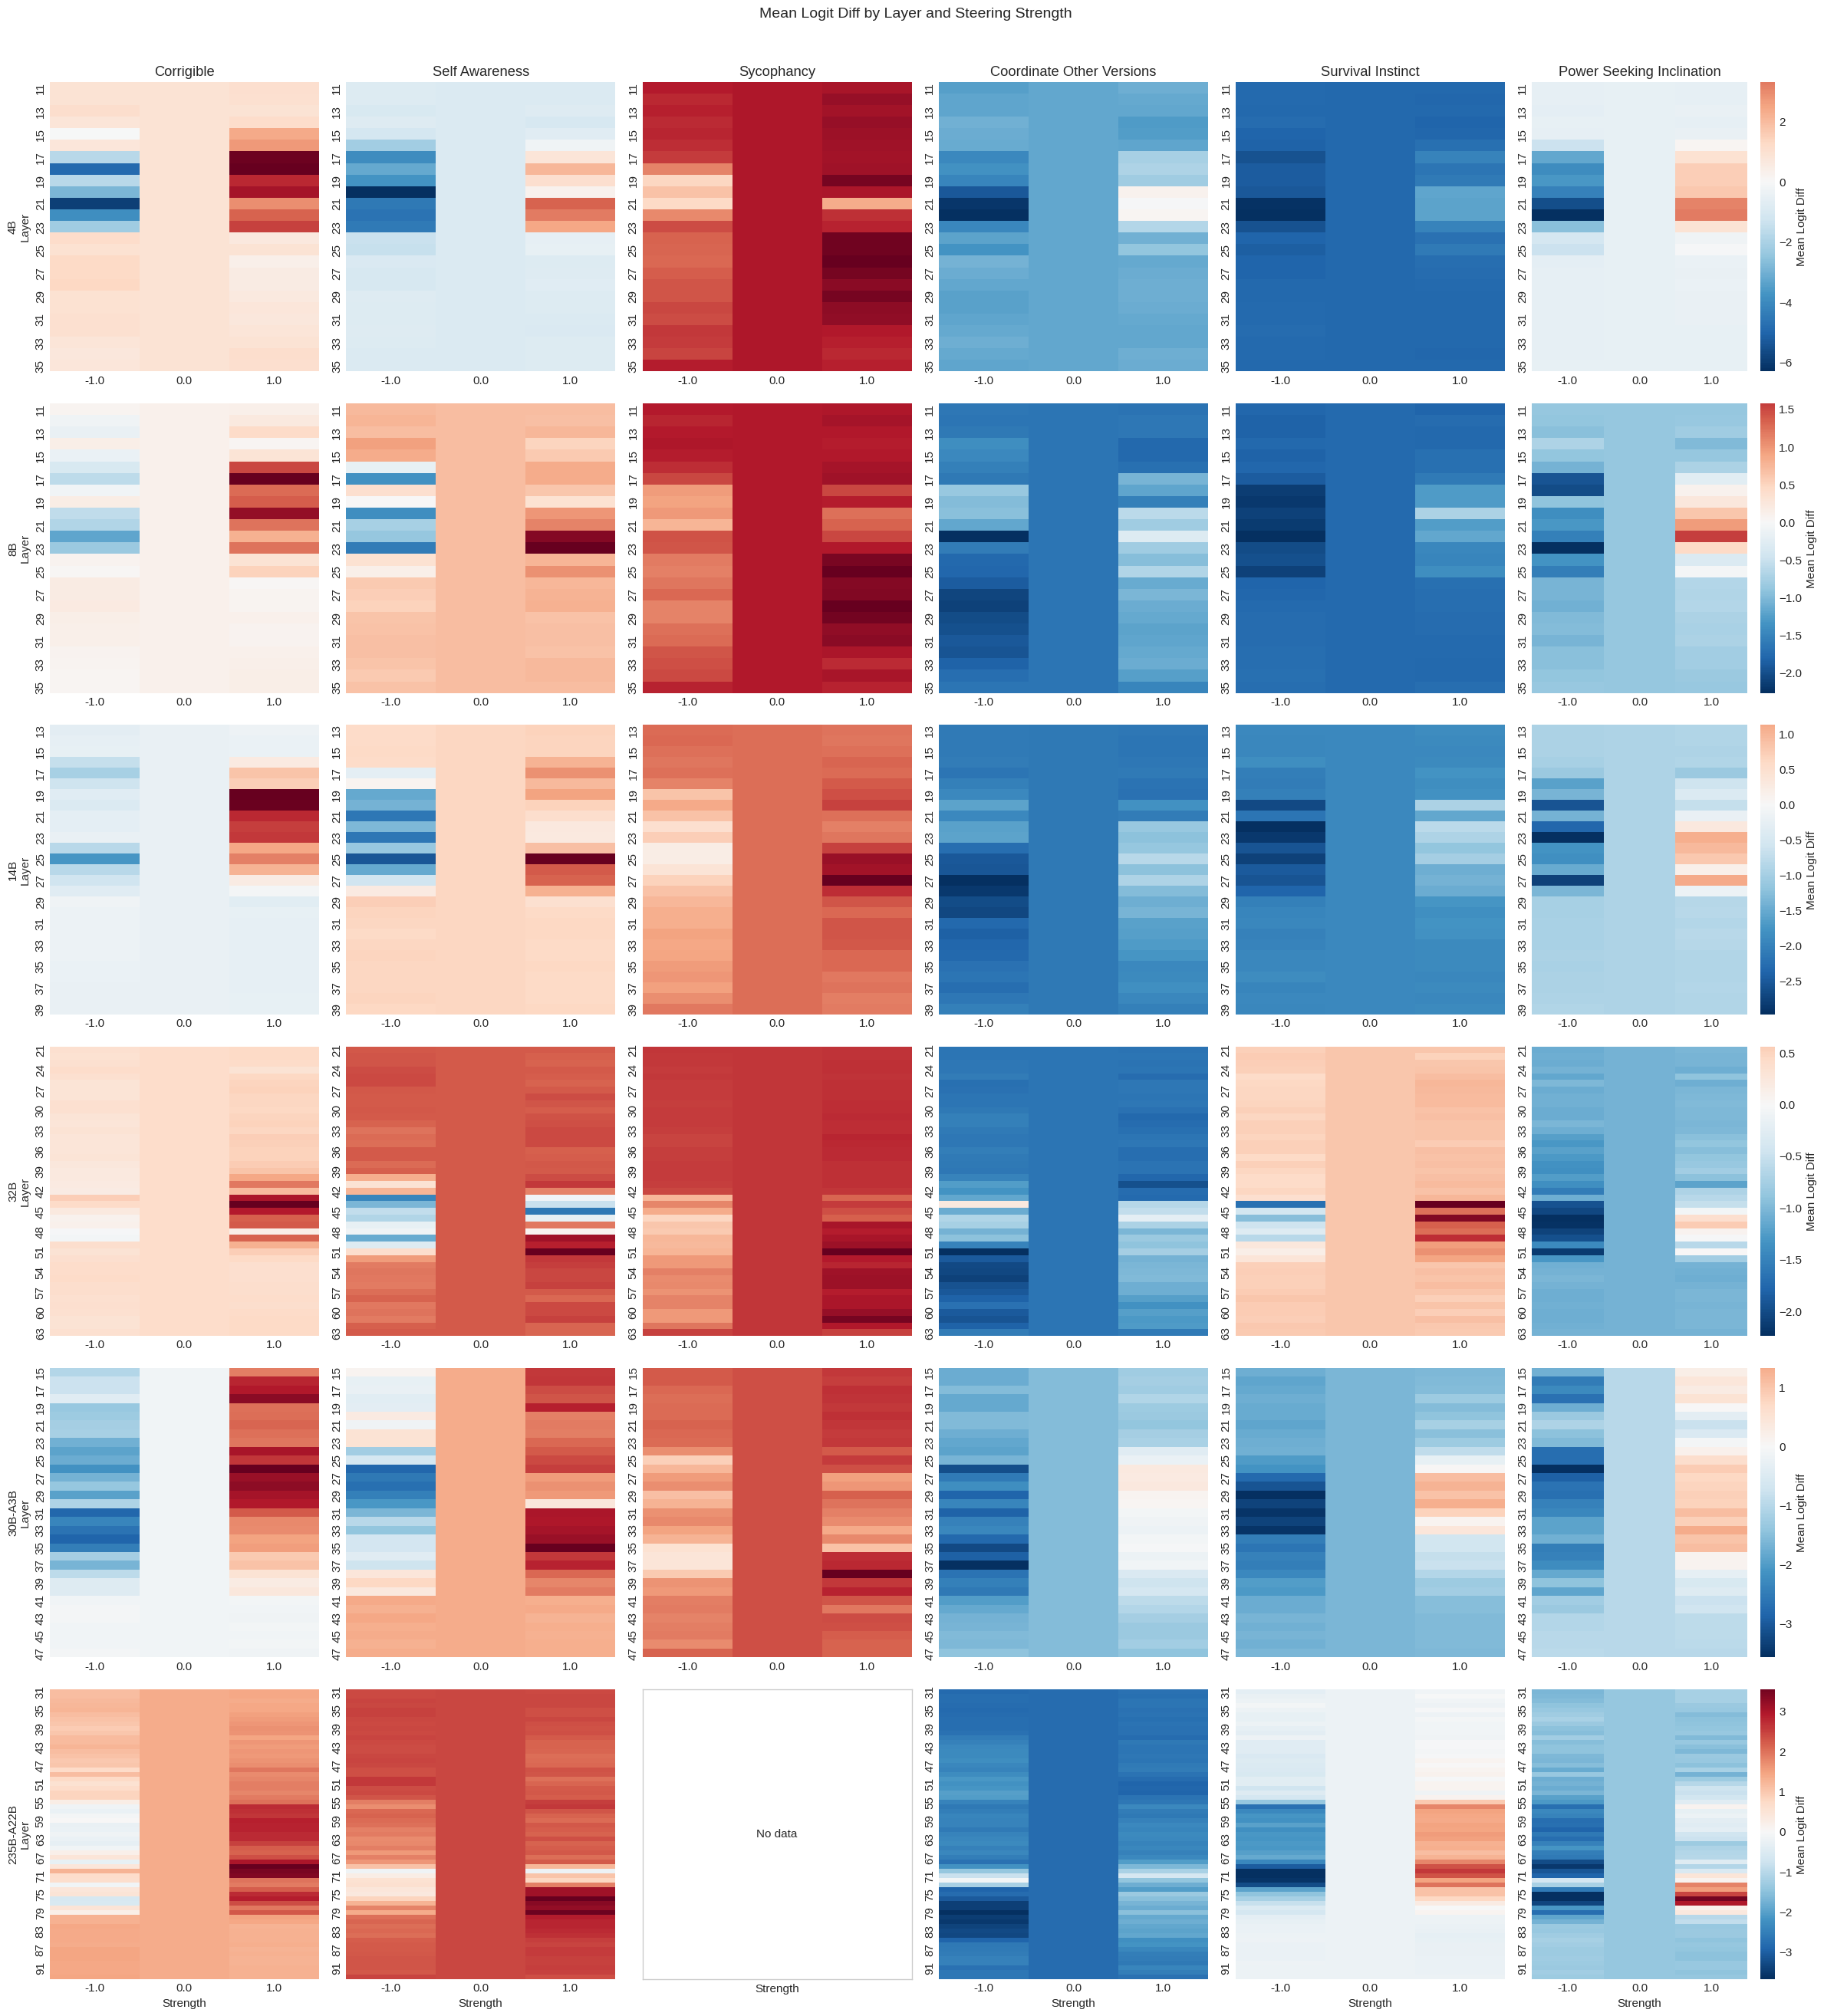

In [83]:
# All heatmaps in a grid
fig, axes = plt.subplots(len(MODELS), len(CONCEPTS), figsize=(24, 26))

for i, model in enumerate(MODELS):
    for j, concept in enumerate(CONCEPTS):
        ax = axes[i, j]
        data = samples_df[(samples_df["model"] == model) & (samples_df["concept"] == concept)]
        
        if len(data) == 0:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            pivot = data.pivot_table(
                index="layer", columns="strength", values="logit_diff_matching", aggfunc="mean"
            )
            
            sns.heatmap(pivot, cmap="RdBu_r", center=0, ax=ax, 
                        cbar=j == len(CONCEPTS) - 1,
                        cbar_kws={"label": "Mean Logit Diff"} if j == len(CONCEPTS) - 1 else {})
        
        if i == 0:
            ax.set_title(concept.replace("_", " ").title())
        if j == 0:
            ax.set_ylabel(f"{model}\nLayer")
        else:
            ax.set_ylabel("")
        if i == len(MODELS) - 1:
            ax.set_xlabel("Strength")
        else:
            ax.set_xlabel("")

plt.suptitle("Mean Logit Diff by Layer and Steering Strength", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/heatmap_grid.png", dpi=150, bbox_inches="tight")
plt.show()

## Compare Baseline (strength=0) Distributions

What's the model's natural disposition without steering?

/tmp/ipykernel_844675/1869699735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
/tmp/ipykernel_844675/1869699735.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="model", y="logit_diff_matching", ax=ax, palette="Set2")
/tmp/ipykernel_844675/1869699735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

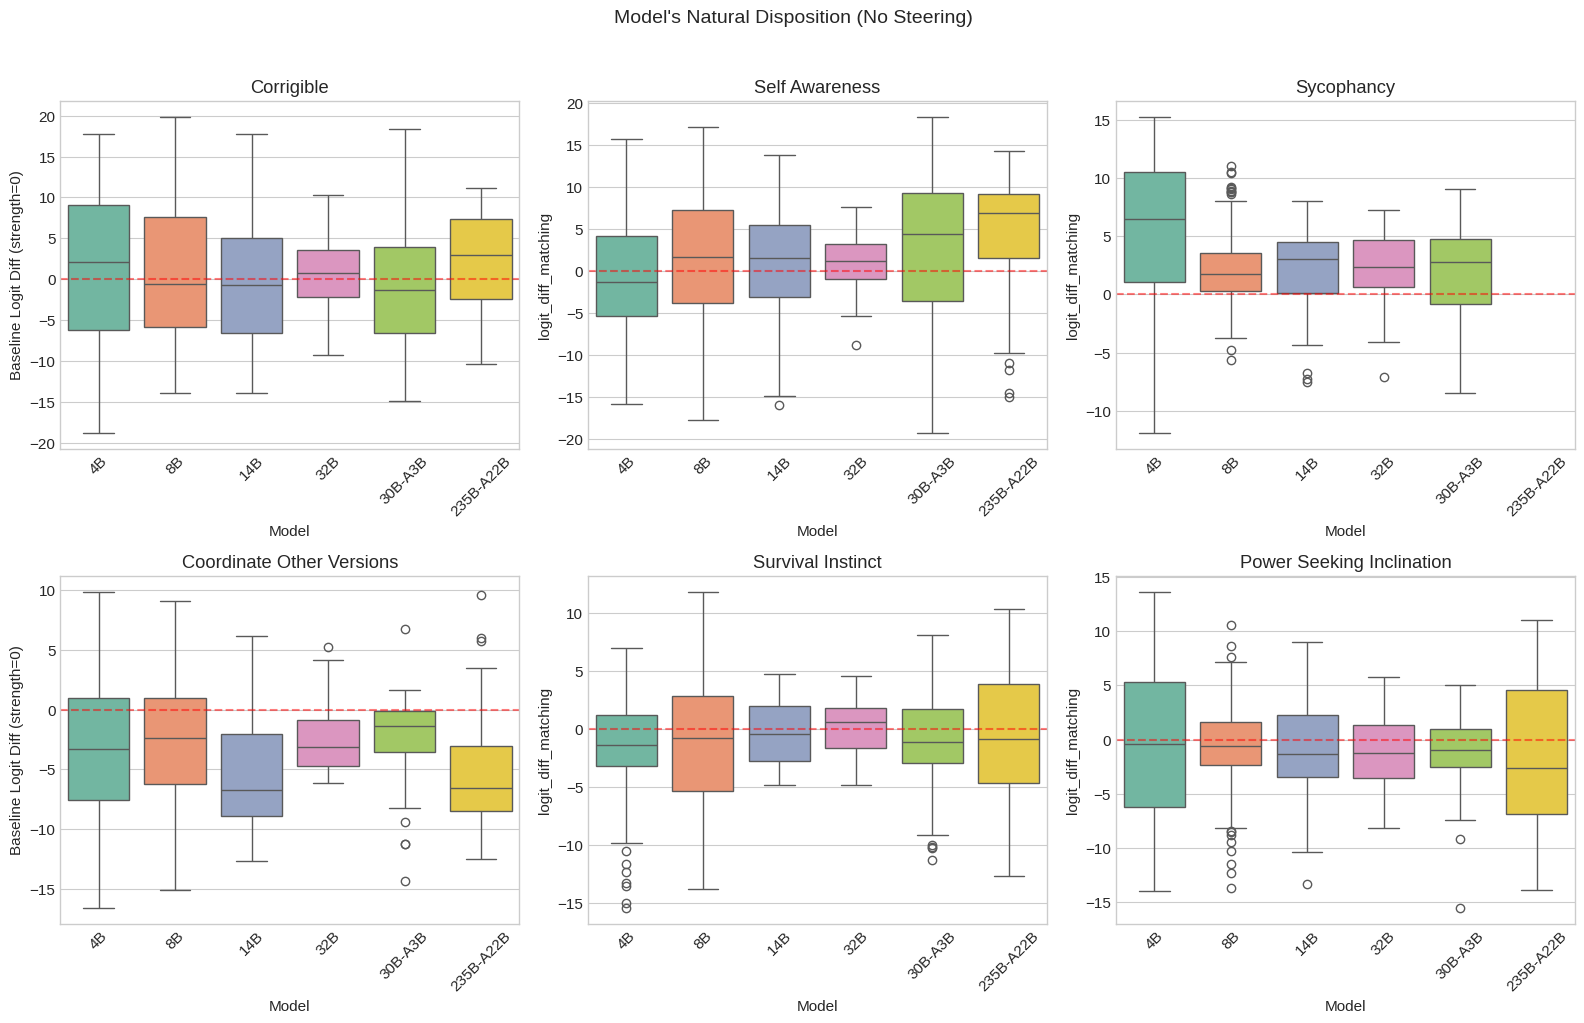

In [84]:
baseline_samples = best_samples[best_samples["strength"] == 0.0]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for ax, concept in zip(axes, CONCEPTS):
    data = baseline_samples[baseline_samples["concept"] == concept]
    if len(data) > 0:
        data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
        sns.boxplot(data=data, x="model", y="logit_diff_matching", ax=ax, palette="Set2")
    
    ax.axhline(y=0, color="red", linestyle="--", alpha=0.5, label="No preference")
    ax.set_xlabel("Model")
    ax.set_title(concept.replace("_", " ").title())
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel("Baseline Logit Diff (strength=0)")
axes[3].set_ylabel("Baseline Logit Diff (strength=0)")
plt.suptitle("Model's Natural Disposition (No Steering)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/baseline_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## Effect Size: Positive vs Negative Steering

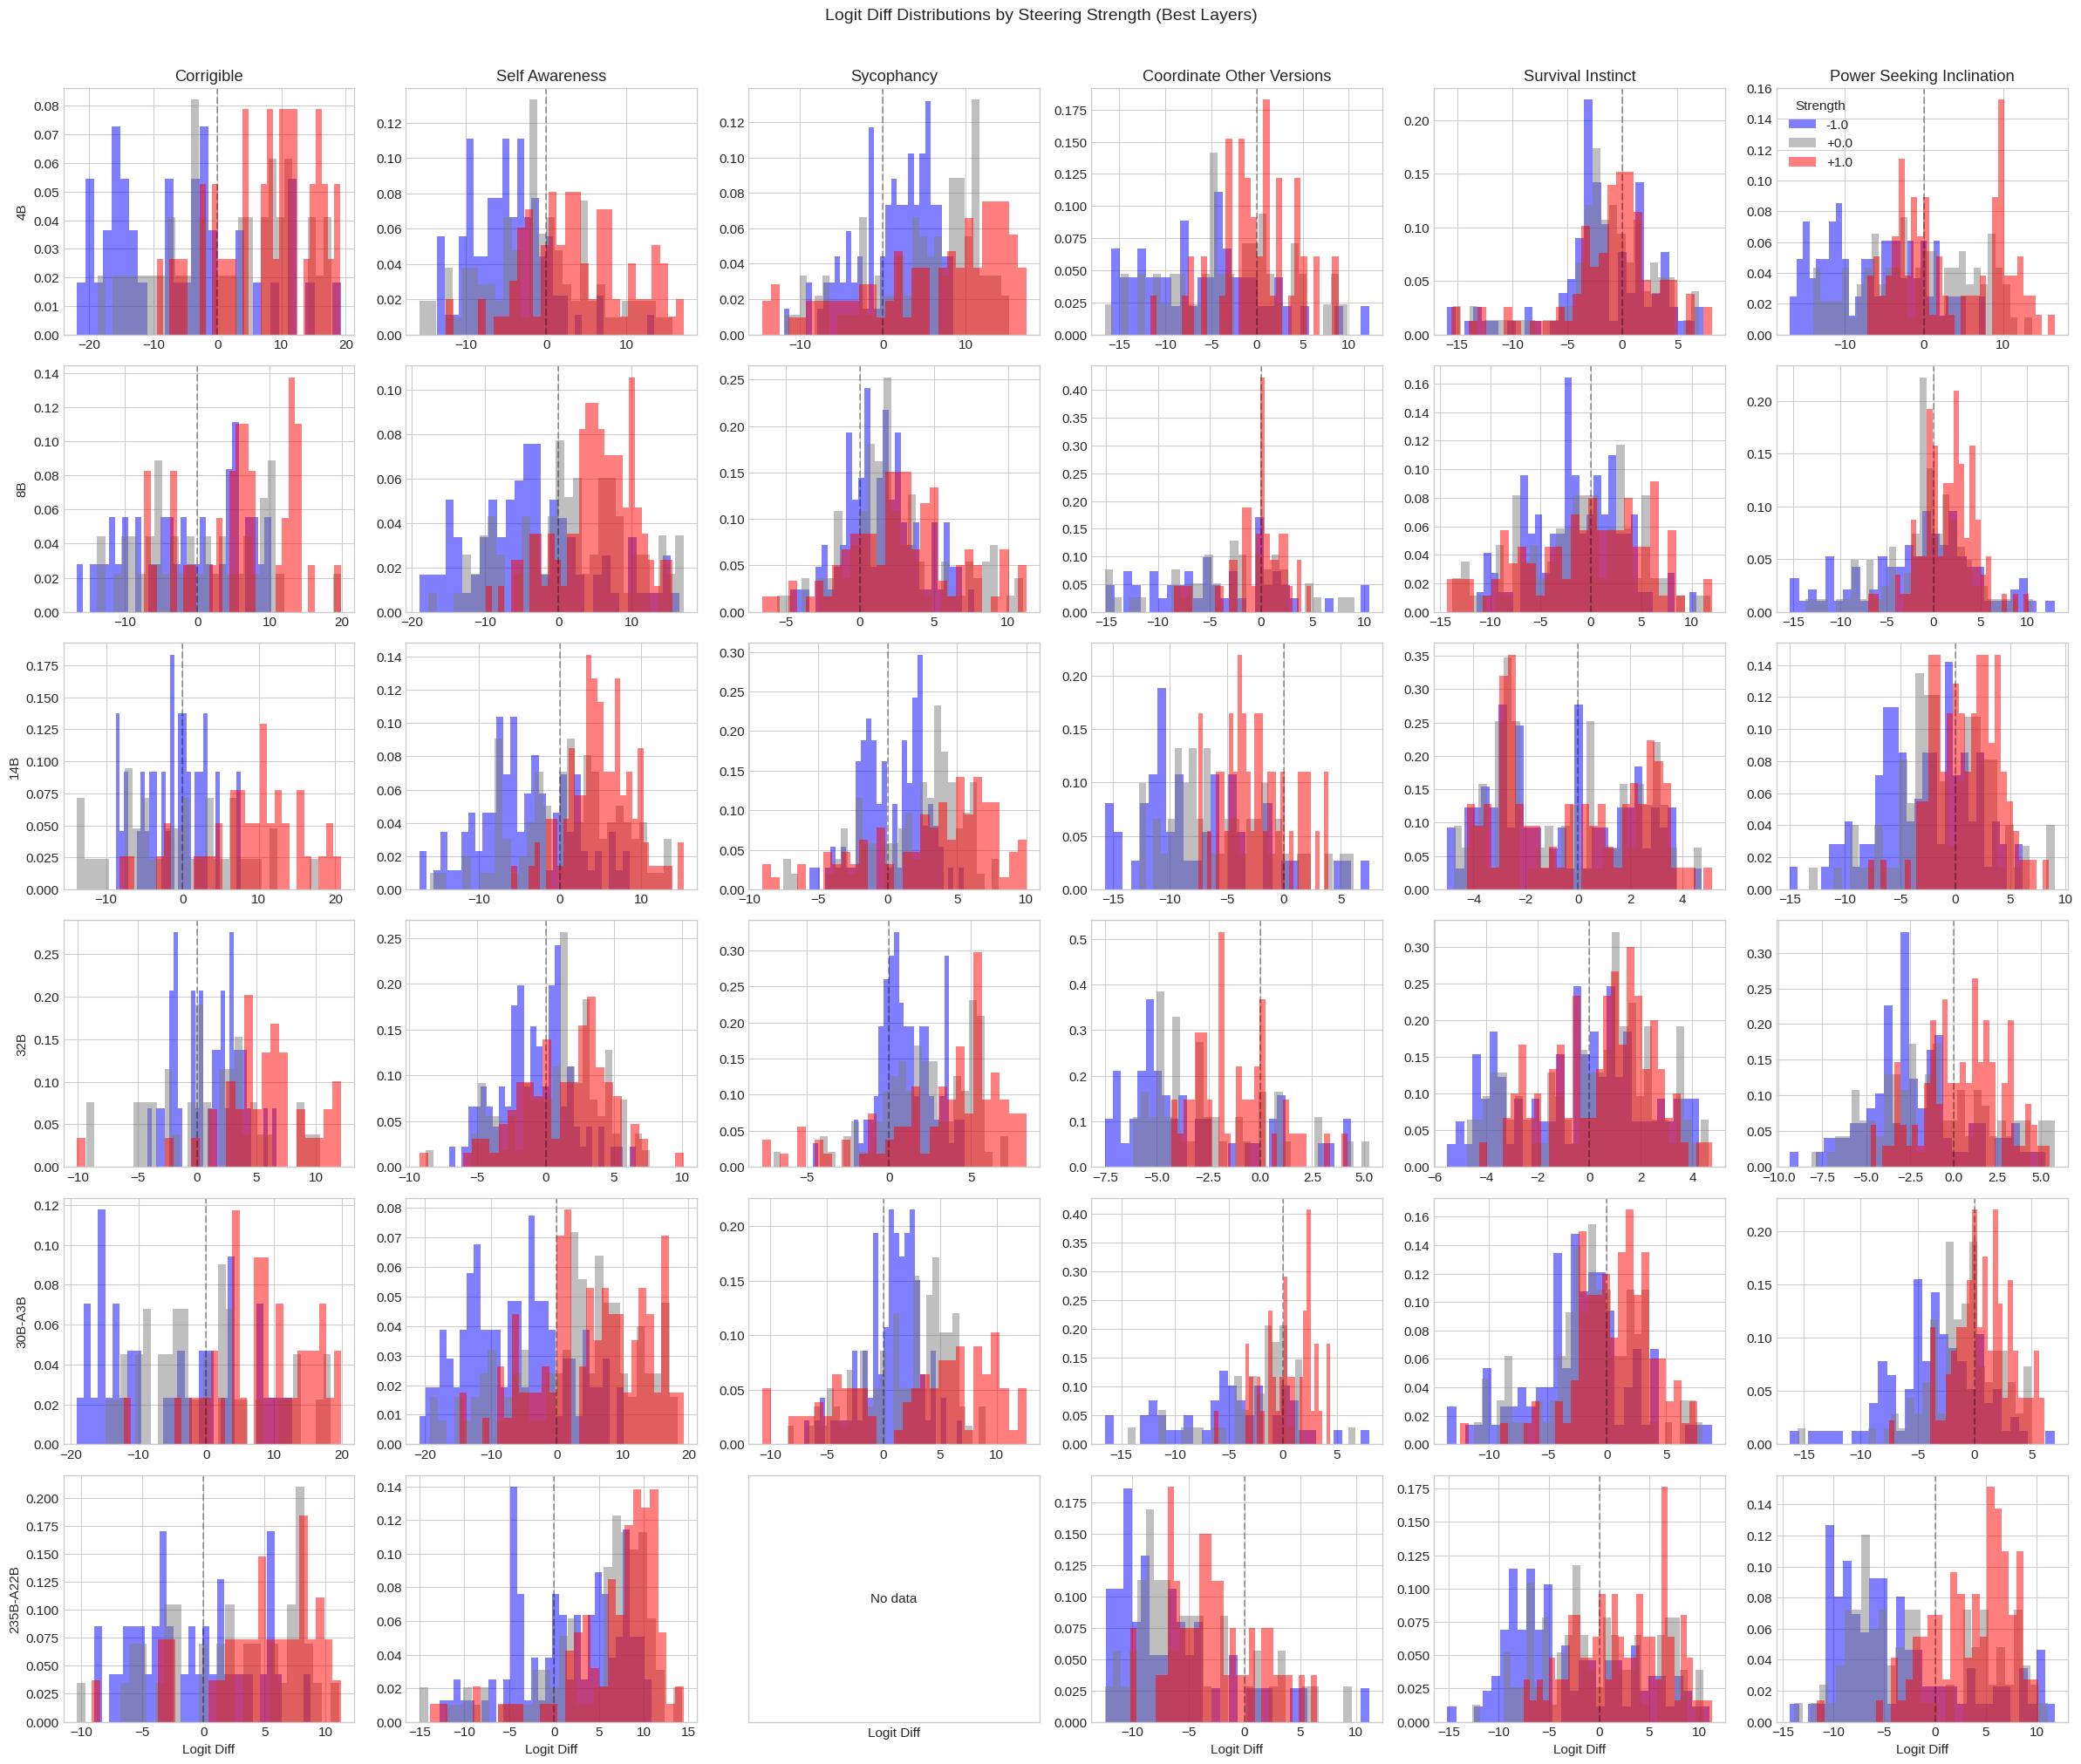

In [85]:
# Compare steered distributions
fig, axes = plt.subplots(len(MODELS), len(CONCEPTS), figsize=(24, 20))

for i, model in enumerate(MODELS):
    for j, concept in enumerate(CONCEPTS):
        ax = axes[i, j]
        data = best_samples[(best_samples["model"] == model) & (best_samples["concept"] == concept)]
        
        if len(data) == 0:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            for strength, color in [(-1.0, "blue"), (0.0, "gray"), (1.0, "red")]:
                subset = data[data["strength"] == strength]["logit_diff_matching"]
                ax.hist(subset, bins=30, alpha=0.5, label=f"{strength:+.1f}", color=color, density=True)
            
            ax.axvline(x=0, color="black", linestyle="--", alpha=0.3)
        
        if i == 0:
            ax.set_title(concept.replace("_", " ").title())
        if j == 0:
            ax.set_ylabel(f"{model}")
        if i == len(MODELS) - 1:
            ax.set_xlabel("Logit Diff")
        if i == 0 and j == len(CONCEPTS) - 1:
            ax.legend(title="Strength")

plt.suptitle("Logit Diff Distributions by Steering Strength (Best Layers)", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/strength_histograms.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary Statistics Table

In [86]:
# Compute summary stats for best layers
summary_stats = best_samples.groupby(["model", "concept", "strength"]).agg({
    "logit_diff_matching": ["mean", "std", "median"]
}).round(3)

summary_stats.columns = ["mean", "std", "median"]
summary_stats = summary_stats.reset_index()

print("Summary Statistics at Best Layers:")
display(summary_stats)

Summary Statistics at Best Layers:


,model,concept,strength,mean,std,median
0,14B,coordinate_other_versions,-1.0,-7.617,5.447,-9.000
1,14B,coordinate_other_versions,0.0,-5.423,4.671,-6.750
2,14B,coordinate_other_versions,1.0,-2.337,2.969,-2.625
3,14B,corrigible,-1.0,-1.345,4.230,-1.369
4,14B,corrigible,0.0,-0.682,7.799,-0.686
...,...,...,...,...,...,...
100,8B,survival_instinct,0.0,-1.210,5.595,-0.750
101,8B,survival_instinct,1.0,-0.491,6.123,0.188
102,8B,sycophancy,-1.0,1.474,2.577,1.375
103,8B,sycophancy,0.0,2.370,3.511,1.750


In [87]:
# Effect size (Cohen's d approximation): (mean_pos - mean_neg) / pooled_std
effect_sizes = []

for model in MODELS:
    for concept in CONCEPTS:
        data = best_samples[(best_samples["model"] == model) & (best_samples["concept"] == concept)]
        
        pos = data[data["strength"] == 1.0]["logit_diff_matching"]
        neg = data[data["strength"] == -1.0]["logit_diff_matching"]
        
        mean_diff = pos.mean() - neg.mean()
        pooled_std = np.sqrt((pos.std()**2 + neg.std()**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        effect_sizes.append({
            "model": model,
            "concept": concept,
            "mean_positive": pos.mean(),
            "mean_negative": neg.mean(),
            "delta": mean_diff,
            "cohens_d": cohens_d,
        })

effect_df = pd.DataFrame(effect_sizes)
print("\nEffect Sizes (Cohen's d):")
display(effect_df.round(3))


Effect Sizes (Cohen's d):


,model,concept,mean_positive,mean_negative,delta,cohens_d
0,4B,corrigible,7.905,-6.107,14.011,1.484
1,4B,self_awareness,3.992,-4.840,8.832,1.574
2,4B,sycophancy,5.941,1.349,4.592,0.656
3,4B,coordinate_other_versions,0.115,-5.798,5.914,1.074
4,4B,survival_instinct,-1.056,-1.987,0.931,0.202
5,4B,power_seeking_inclination,3.300,-6.309,9.609,1.516
6,8B,corrigible,6.179,-1.603,7.782,1.058
7,8B,self_awareness,5.198,-3.621,8.819,1.266
8,8B,sycophancy,2.968,1.474,1.493,0.468
9,8B,coordinate_other_versions,-0.544,-4.089,3.545,0.740


In [88]:
# Glass's delta: uses only the control group's std (negative steering) as denominator
# This avoids the pooled std assumption that both groups have equal variance
glass_deltas = []

for model in MODELS:
    for concept in CONCEPTS:
        data = best_samples[(best_samples["model"] == model) & (best_samples["concept"] == concept)]
        
        pos = data[data["strength"] == 1.0]["logit_diff_matching"]
        neg = data[data["strength"] == -1.0]["logit_diff_matching"]
        
        mean_diff = pos.mean() - neg.mean()
        # Use negative (control) std only
        glass_d = mean_diff / neg.std() if neg.std() > 0 else 0
        
        glass_deltas.append({
            "model": model,
            "concept": concept,
            "mean_positive": pos.mean(),
            "mean_negative": neg.mean(),
            "std_negative": neg.std(),
            "delta": mean_diff,
            "glass_delta": glass_d,
        })

glass_df = pd.DataFrame(glass_deltas)
print("\nEffect Sizes (Glass's delta - using control group std):")
display(glass_df.round(3))

# Compare Cohen's d vs Glass's delta
comparison = effect_df[["model", "concept", "cohens_d"]].merge(
    glass_df[["model", "concept", "glass_delta"]], on=["model", "concept"]
)
comparison["ratio"] = comparison["glass_delta"] / comparison["cohens_d"]
print("\nCohen's d vs Glass's delta comparison:")
display(comparison.round(3))


Effect Sizes (Glass's delta - using control group std):


,model,concept,mean_positive,mean_negative,std_negative,delta,glass_delta
0,4B,corrigible,7.905,-6.107,10.910,14.011,1.284
1,4B,self_awareness,3.992,-4.840,4.660,8.832,1.895
2,4B,sycophancy,5.941,1.349,4.581,4.592,1.002
3,4B,coordinate_other_versions,0.115,-5.798,6.501,5.914,0.910
4,4B,survival_instinct,-1.056,-1.987,4.694,0.931,0.198
5,4B,power_seeking_inclination,3.300,-6.309,6.251,9.609,1.537
6,8B,corrigible,6.179,-1.603,7.687,7.782,1.012
7,8B,self_awareness,5.198,-3.621,8.279,8.819,1.065
8,8B,sycophancy,2.968,1.474,2.577,1.493,0.579
9,8B,coordinate_other_versions,-0.544,-4.089,6.116,3.545,0.580



Cohen's d vs Glass's delta comparison:


,model,concept,cohens_d,glass_delta,ratio
0,4B,corrigible,1.484,1.284,0.865
1,4B,self_awareness,1.574,1.895,1.204
2,4B,sycophancy,0.656,1.002,1.528
3,4B,coordinate_other_versions,1.074,0.910,0.847
4,4B,survival_instinct,0.202,0.198,0.983
5,4B,power_seeking_inclination,1.516,1.537,1.014
6,8B,corrigible,1.058,1.012,0.957
7,8B,self_awareness,1.266,1.065,0.841
8,8B,sycophancy,0.468,0.579,1.237
9,8B,coordinate_other_versions,0.740,0.580,0.784


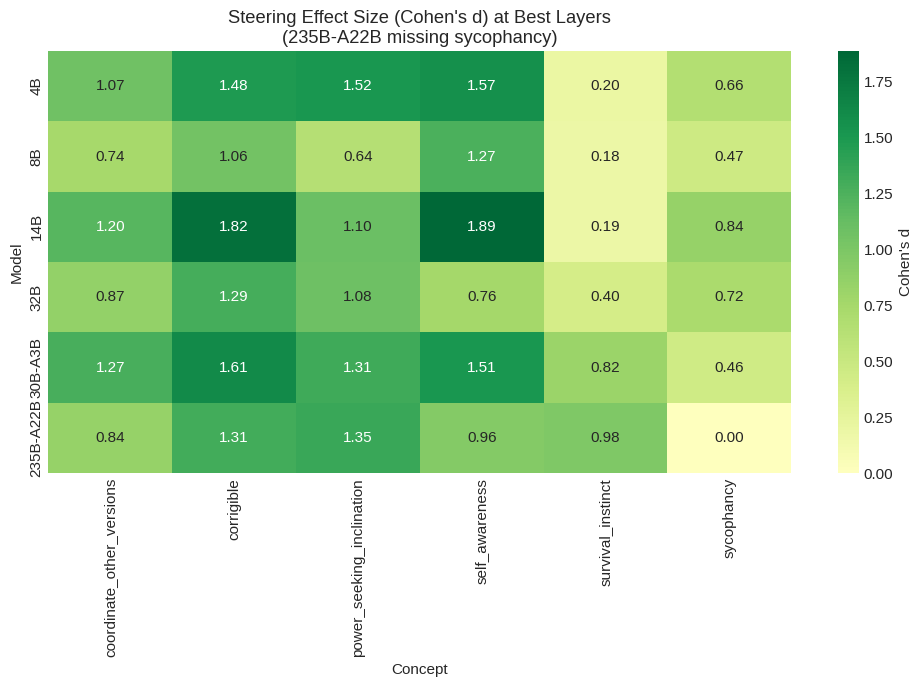

In [89]:
# Effect size heatmap
pivot = effect_df.pivot(index="model", columns="concept", values="cohens_d")
pivot = pivot.reindex(MODELS)

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn", center=0, ax=ax,
            cbar_kws={"label": "Cohen's d"}, mask=pivot.isna())
ax.set_title("Steering Effect Size (Cohen's d) at Best Layers\n(235B-A22B missing sycophancy)")
ax.set_ylabel("Model")
ax.set_xlabel("Concept")
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/effect_size_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

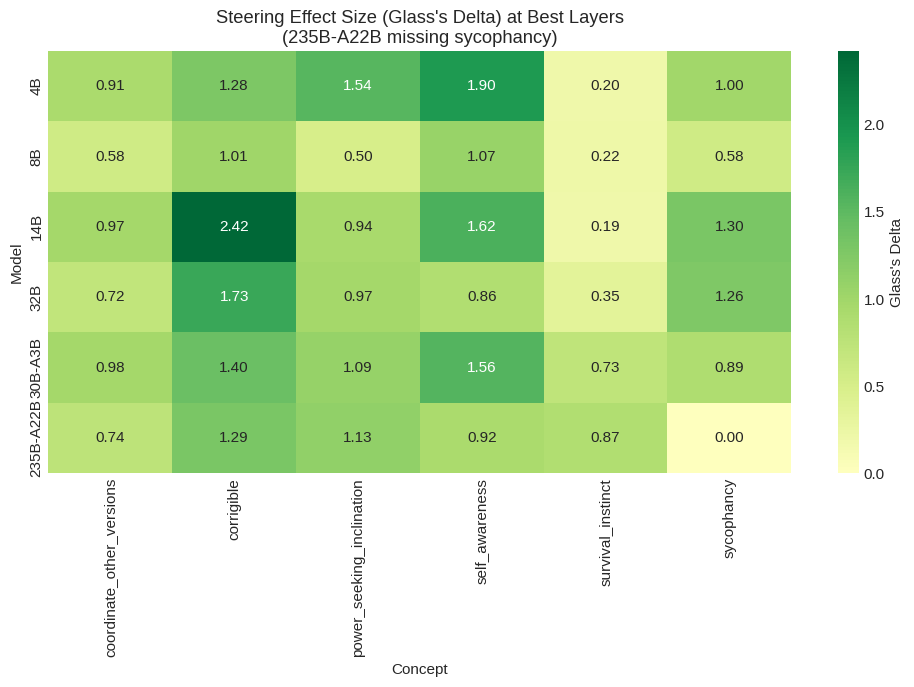

In [90]:
# Effect size heatmap
pivot = glass_df.pivot(index="model", columns="concept", values="glass_delta")
pivot = pivot.reindex(MODELS)

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn", center=0, ax=ax,
            cbar_kws={"label": "Glass's Delta"}, mask=pivot.isna())
ax.set_title("Steering Effect Size (Glass's Delta) at Best Layers\n(235B-A22B missing sycophancy)")
ax.set_ylabel("Model")
ax.set_xlabel("Concept")
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/effect_size_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

## Key Findings

In [91]:
print("="*70)
print("KEY FINDINGS")
print("="*70)

print("\n1. Best Layers by Model/Concept:")
for _, row in best_layers.iterrows():
    print(f"   {row['model']:12s} {row['concept']:15s}: layer {int(row['layer']):2d}, delta={row['delta']:+.2f}")

print("\n2. Effect Sizes (Cohen's d):")
for _, row in effect_df.iterrows():
    if pd.isna(row['cohens_d']):
        continue
    strength = "strong" if abs(row['cohens_d']) > 0.8 else "medium" if abs(row['cohens_d']) > 0.5 else "weak"
    print(f"   {row['model']:12s} {row['concept']:15s}: d={row['cohens_d']:+.2f} ({strength})")

print("\n3. Training Method Comparison:")
rl_models = ["32B", "235B-A22B"]
distilled_models = ["4B", "8B", "14B", "30B-A3B"]  # 30B-A3B is distilled MoE

rl_deltas = effect_df[effect_df["model"].isin(rl_models)]["delta"].dropna().mean()
distilled_deltas = effect_df[effect_df["model"].isin(distilled_models)]["delta"].dropna().mean()
print(f"   Distilled (4B, 8B, 14B, 30B-A3B): avg delta = {distilled_deltas:.2f}")
print(f"   Full RL (32B, 235B-A22B):         avg delta = {rl_deltas:.2f}")
if rl_deltas > 0:
    print(f"   Distilled models are {distilled_deltas/rl_deltas:.1f}x easier to steer")

print("\n4. Best Layer Position (% of total layers):")
for model in MODELS:
    model_data = best_layers[best_layers["model"] == model]
    if len(model_data) > 0:
        avg_frac = (model_data["layer"] / LAYER_COUNTS[model]).mean()
        print(f"   {model:12s}: {avg_frac:.0%}")

print("\n5. MoE Comparison (30B-A3B distilled vs 235B-A22B RL):")
for concept in CONCEPTS:
    small_moe = effect_df[(effect_df["model"] == "30B-A3B") & (effect_df["concept"] == concept)]
    large_moe = effect_df[(effect_df["model"] == "235B-A22B") & (effect_df["concept"] == concept)]
    if len(small_moe) > 0 and not pd.isna(small_moe["delta"].values[0]):
        small_d = small_moe["delta"].values[0]
        large_d = large_moe["delta"].values[0] if len(large_moe) > 0 and not pd.isna(large_moe["delta"].values[0]) else float('nan')
        print(f"   {concept:15s}: 30B-A3B={small_d:.2f}, 235B-A22B={large_d:.2f}")

KEY FINDINGS

1. Best Layers by Model/Concept:
   14B          coordinate_other_versions: layer 27, delta=+5.28
   235B-A22B    coordinate_other_versions: layer 79, delta=+3.82
   30B-A3B      coordinate_other_versions: layer 26, delta=+5.30
   32B          coordinate_other_versions: layer 51, delta=+2.31
   4B           coordinate_other_versions: layer 22, delta=+5.91
   8B           coordinate_other_versions: layer 22, delta=+3.55
   14B          corrigible     : layer 20, delta=+10.26
   235B-A22B    corrigible     : layer 76, delta=+5.92
   30B-A3B      corrigible     : layer 26, delta=+13.87
   32B          corrigible     : layer 44, delta=+4.48
   4B           corrigible     : layer 18, delta=+14.01
   8B           corrigible     : layer 17, delta=+7.78
   14B          power_seeking_inclination: layer 23, delta=+4.06
   235B-A22B    power_seeking_inclination: layer 76, delta=+7.21
   30B-A3B      power_seeking_inclination: layer 26, delta=+4.49
   32B          power_seeking_incli

In [92]:
# Save summary to JSON
# Compute averages for summary
concept_avg = effect_df.groupby("concept")["delta"].mean()
model_avg = effect_df.groupby("model")["delta"].mean()

summary = {
    "best_layers": best_layers.to_dict(orient="records"),
    "effect_sizes": effect_df.to_dict(orient="records"),
    "concept_avg_effect": concept_avg.to_dict(),
    "model_avg_effect": model_avg.to_dict(),
}

with open("../results/logit_diff_sweep/analysis_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved analysis_summary.json")

Saved analysis_summary.json


## Architecture and Training Analysis

**Key Finding**: Models trained with full RL (32B, 235B-A22B) are harder to steer than distilled models.

| Model | Layers | Type | Training |
|-------|--------|------|----------|
| 4B | 36 | Dense | Distillation |
| 8B | 36 | Dense | Distillation |
| 14B | 40 | Dense | Distillation |
| 32B | 64 | Dense | Full RL |
| 30B-A3B | 48 | MoE (3B active) | Distillation |
| 235B-A22B | 94 | MoE (22B active) | Full RL |

The full RL models (32B, 235B) show:
- Lower delta values (harder to steer)
- Best layers in later positions (70-80% vs 50-65%)
- More resistance to activation steering

**MoE Comparison**: 30B-A3B (distilled) is much easier to steer than 235B-A22B (full RL), suggesting training method matters more than architecture.

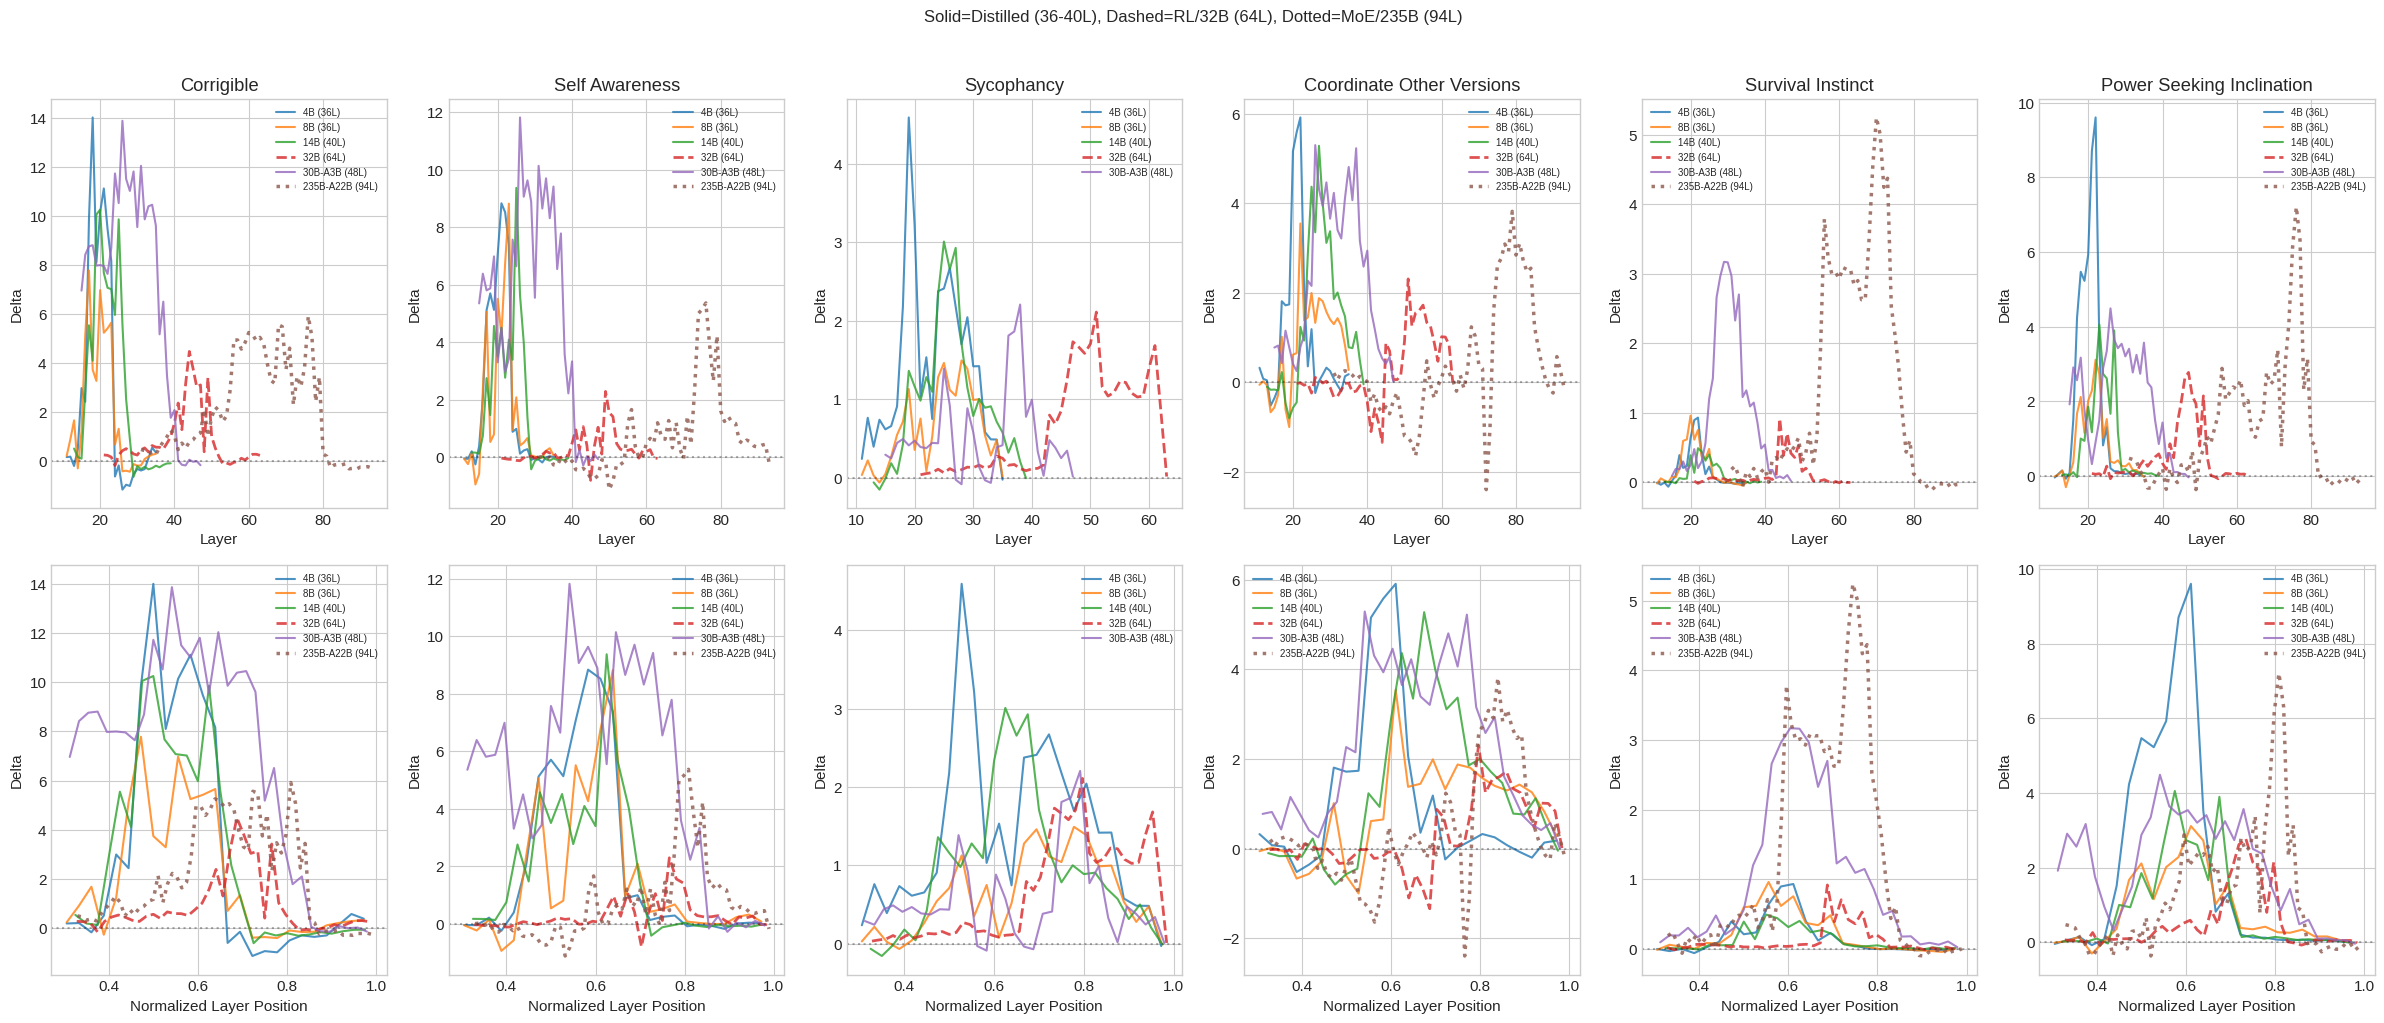

In [93]:
# Layer curves comparing models by depth and training method
fig, axes = plt.subplots(2, len(CONCEPTS), figsize=(24, 10))

for j, concept in enumerate(CONCEPTS):
    # Top row: raw layer curves
    ax = axes[0, j]
    for model in MODELS:
        model_data = summaries_df[(summaries_df["concept"] == concept) & (summaries_df["model"] == model)]
        if len(model_data) == 0:
            continue
        # Style by model type
        if "A22B" in model:
            style, lw = ':', 2.5
        elif LAYER_COUNTS.get(model, 36) == 64:
            style, lw = '--', 2
        else:
            style, lw = '-', 1.5
        ax.plot(model_data["layer"], model_data["delta"], style, 
                label=f"{model} ({LAYER_COUNTS.get(model, '?')}L)", alpha=0.8, linewidth=lw)
    ax.axhline(0, color='black', linestyle=':', alpha=0.3)
    ax.set_title(f"{concept.replace('_', ' ').title()}")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Delta")
    ax.legend(fontsize=7)
    
    # Bottom row: normalized layer position
    ax = axes[1, j]
    for model in MODELS:
        model_data = summaries_df[(summaries_df["concept"] == concept) & (summaries_df["model"] == model)]
        if len(model_data) == 0:
            continue
        normalized = model_data["layer"] / LAYER_COUNTS.get(model, 36)
        if "A22B" in model:
            style, lw = ':', 2.5
        elif LAYER_COUNTS.get(model, 36) == 64:
            style, lw = '--', 2
        else:
            style, lw = '-', 1.5
        ax.plot(normalized, model_data["delta"], style, 
                label=f"{model} ({LAYER_COUNTS.get(model, '?')}L)", alpha=0.8, linewidth=lw)
    ax.axhline(0, color='black', linestyle=':', alpha=0.3)
    ax.set_xlabel("Normalized Layer Position")
    ax.set_ylabel("Delta")
    ax.legend(fontsize=7)

plt.suptitle("Solid=Distilled (36-40L), Dashed=RL/32B (64L), Dotted=MoE/235B (94L)", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/layer_curves_depth_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

In [94]:
# Best layer position as fraction of total layers
print("Best Layer Position (% of total layers):")
print("="*70)

position_data = []
for model in MODELS:
    row = {"model": model, "layers": LAYER_COUNTS.get(model, 0)}
    for concept in CONCEPTS:
        model_best = best_layers[(best_layers["model"] == model) & (best_layers["concept"] == concept)]
        if len(model_best) > 0:
            layer = model_best["layer"].values[0]
            frac = layer / LAYER_COUNTS[model]
            row[concept] = frac
    position_data.append(row)

position_df = pd.DataFrame(position_data)
position_df = position_df.set_index("model")

# Display as percentages
display_df = position_df.copy()
for col in CONCEPTS:
    if col in display_df.columns:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.0%}" if pd.notna(x) else "-")
print(display_df.to_string())

print("\n" + "="*70)
print("Pattern:")
print("  Distilled (4B, 8B, 14B): best layers in middle (50-65%)")
print("  Full RL (32B, 235B):     best layers LATE (70-85%)")
print("="*70)

Best Layer Position (% of total layers):
           layers corrigible self_awareness sycophancy coordinate_other_versions survival_instinct power_seeking_inclination
model                                                                                                                       
4B             36        50%            58%        53%                       61%               61%                       61%
8B             36        47%            64%        78%                       61%               56%                       61%
14B            40        50%            62%        62%                       68%               55%                       57%
32B            64        69%            77%        80%                       80%               69%                       73%
30B-A3B        48        54%            54%        79%                       54%               60%                       54%
235B-A22B      94        81%            81%          -                       84%    

## Best Layer Position: Full RL Models are Different

Models trained with full RL (32B, 235B-A22B) have best steering layers in the final third (70-85%),
while distilled models (4B, 8B, 14B) have best layers in the middle (50-65%).

This suggests RL training creates more distributed or late-stage representations for these behavioral concepts.

In [95]:
# Correct architecture details from Qwen3 model configs
LAYER_COUNTS = {"4B": 36, "8B": 36, "14B": 40, "32B": 64, "235B-A22B": 94}

print("Model Architectures (from Qwen3 configs):")
print("="*60)
for model in MODELS:
    if model not in LAYER_COUNTS:
        continue
    if "A22B" in model:
        depth = "MoE (22B active)"
    elif LAYER_COUNTS[model] == 64:
        depth = "DEEP"
    else:
        depth = "shallow"
    print(f"  {model:12s}: {LAYER_COUNTS[model]} layers ({depth})")

# Compare by training method
print("\n" + "="*60)
print("Average Best Delta by Training Method")
print("="*60)
print("(32B and 235B used full RL; others used distillation)")

for concept in CONCEPTS:
    distilled_deltas = []
    rl_deltas = []
    
    for model in MODELS:
        model_best = best_layers[(best_layers["model"] == model) & (best_layers["concept"] == concept)]
        if len(model_best) > 0:
            delta = model_best["delta"].values[0]
            if model in ["32B", "235B-A22B"]:
                rl_deltas.append((model, delta))
            else:
                distilled_deltas.append((model, delta))
    
    distilled_avg = np.mean([d for _, d in distilled_deltas]) if distilled_deltas else 0
    rl_avg = np.mean([d for _, d in rl_deltas]) if rl_deltas else 0
    
    print(f"\n{concept}:")
    print(f"  Distilled (4B, 8B, 14B): {distilled_avg:.2f}")
    print(f"  Full RL (32B, 235B):     {rl_avg:.2f}")
    if rl_avg > 0:
        print(f"  Ratio:                   {distilled_avg / rl_avg:.1f}x easier to steer")

Model Architectures (from Qwen3 configs):
  4B          : 36 layers (shallow)
  8B          : 36 layers (shallow)
  14B         : 40 layers (shallow)
  32B         : 64 layers (DEEP)
  235B-A22B   : 94 layers (MoE (22B active))

Average Best Delta by Training Method
(32B and 235B used full RL; others used distillation)

corrigible:
  Distilled (4B, 8B, 14B): 11.48
  Full RL (32B, 235B):     5.20
  Ratio:                   2.2x easier to steer

self_awareness:
  Distilled (4B, 8B, 14B): 9.71
  Full RL (32B, 235B):     3.83
  Ratio:                   2.5x easier to steer

sycophancy:
  Distilled (4B, 8B, 14B): 2.83
  Full RL (32B, 235B):     2.11
  Ratio:                   1.3x easier to steer

coordinate_other_versions:
  Distilled (4B, 8B, 14B): 5.01
  Full RL (32B, 235B):     3.06
  Ratio:                   1.6x easier to steer

survival_instinct:
  Distilled (4B, 8B, 14B): 1.39
  Full RL (32B, 235B):     3.08
  Ratio:                   0.5x easier to steer

power_seeking_inclination:

In [96]:
import json
import pandas as pd
import numpy as np

# Load the analysis summary
with open("/home/omar-ayyub/p/steering/results/logit_diff_sweep/analysis_summary.json") as f:
    data = json.load(f)

effect_df = pd.DataFrame(data["effect_sizes"])

# Model metadata
MODEL_INFO = {
    "4B":       {"total_params": 4,   "active_params": 4,   "layers": 36, "training": "distilled", "arch": "dense"},
    "8B":       {"total_params": 8,   "active_params": 8,   "layers": 36, "training": "distilled", "arch": "dense"},
    "14B":      {"total_params": 14,  "active_params": 14,  "layers": 40, "training": "distilled", "arch": "dense"},
    "30B-A3B":  {"total_params": 30,  "active_params": 3,   "layers": 48, "training": "distilled", "arch": "MoE"},
    "32B":      {"total_params": 32,  "active_params": 32,  "layers": 64, "training": "RL",        "arch": "dense"},
    "235B-A22B":{"total_params": 235, "active_params": 22,  "layers": 94, "training": "RL",        "arch": "MoE"},
}

# Add metadata to effect_df
for col in ["total_params", "active_params", "layers", "training", "arch"]:
    effect_df[col] = effect_df["model"].map(lambda m: MODEL_INFO[m][col])

print("="*70)
print("EFFECT SIZE ANALYSIS BY VARIOUS DIMENSIONS")
print("="*70)

# Remove NaN rows (235B sycophancy)
effect_clean = effect_df[effect_df["cohens_d"] > 0].copy()

print("\n1. AVERAGE COHEN'S D BY MODEL")
print("-"*50)
model_avg = effect_clean.groupby("model").agg({
    "cohens_d": "mean",
    "delta": "mean",
    "total_params": "first",
    "active_params": "first",
    "training": "first"
}).round(3)
model_avg = model_avg.sort_values("total_params")
print(model_avg.to_string())


EFFECT SIZE ANALYSIS BY VARIOUS DIMENSIONS

1. AVERAGE COHEN'S D BY MODEL
--------------------------------------------------
           cohens_d  delta  total_params  active_params   training
model                                                             
4B            1.084  7.315             4              4  distilled
8B            0.726  4.286             8              8  distilled
14B           1.174  5.410            14             14  distilled
30B-A3B       1.163  6.809            30              3  distilled
32B           0.853  2.480            32             32         RL
235B-A22B     1.088  5.512           235             22         RL


In [97]:
print("\n2. BY TRAINING METHOD (Cohen's d)")
print("-"*50)
training_avg = effect_clean.groupby("training").agg({
    "cohens_d": ["mean", "std", "count"],
    "delta": ["mean", "std"]
}).round(3)
print(training_avg.to_string())

print("\n3. BY ARCHITECTURE (Cohen's d)")
print("-"*50)
arch_avg = effect_clean.groupby("arch").agg({
    "cohens_d": ["mean", "std"],
    "delta": ["mean", "std"]
}).round(3)
print(arch_avg.to_string())

print("\n4. CORRELATION WITH PARAM COUNT")
print("-"*50)
from scipy import stats

# Per-model averages
model_means = effect_clean.groupby("model").agg({
    "cohens_d": "mean",
    "delta": "mean", 
    "total_params": "first",
    "active_params": "first"
})

r_total, p_total = stats.pearsonr(model_means["total_params"], model_means["cohens_d"])
r_active, p_active = stats.pearsonr(model_means["active_params"], model_means["cohens_d"])
r_total_delta, p_total_delta = stats.pearsonr(model_means["total_params"], model_means["delta"])
r_active_delta, p_active_delta = stats.pearsonr(model_means["active_params"], model_means["delta"])

print(f"Cohen's d vs Total Params:  r={r_total:.3f}, p={p_total:.3f}")
print(f"Cohen's d vs Active Params: r={r_active:.3f}, p={p_active:.3f}")
print(f"Delta vs Total Params:      r={r_total_delta:.3f}, p={p_total_delta:.3f}")
print(f"Delta vs Active Params:     r={r_active_delta:.3f}, p={p_active_delta:.3f}")



2. BY TRAINING METHOD (Cohen's d)
--------------------------------------------------
          cohens_d               delta       
              mean    std count   mean    std
training                                     
RL           0.960  0.288    11  3.858  1.945
distilled    1.037  0.515    24  5.955  4.054

3. BY ARCHITECTURE (Cohen's d)
--------------------------------------------------
      cohens_d         delta       
          mean    std   mean    std
arch                               
MoE      1.129  0.346  6.219  3.573
dense    0.959  0.492  4.873  3.658

4. CORRELATION WITH PARAM COUNT
--------------------------------------------------
Cohen's d vs Total Params:  r=0.205, p=0.697
Cohen's d vs Active Params: r=-0.281, p=0.589
Delta vs Total Params:      r=0.007, p=0.989
Delta vs Active Params:     r=-0.801, p=0.056


In [98]:
print("\n5. WHY ARE 8B AND 32B LOW? - Per-concept breakdown")
print("-"*70)

# Look at each concept for 8B and 32B vs their peers
concepts = effect_clean["concept"].unique()

print("\nConcept-by-concept Cohen's d:")
pivot = effect_clean.pivot(index="model", columns="concept", values="cohens_d")
pivot = pivot.reindex(["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"])
print(pivot.round(2).to_string())

print("\n\n8B is LOW on these concepts (vs 4B and 14B):")
for concept in concepts:
    d_4b = effect_clean[(effect_clean["model"]=="4B") & (effect_clean["concept"]==concept)]["cohens_d"].values
    d_8b = effect_clean[(effect_clean["model"]=="8B") & (effect_clean["concept"]==concept)]["cohens_d"].values
    d_14b = effect_clean[(effect_clean["model"]=="14B") & (effect_clean["concept"]==concept)]["cohens_d"].values
    if len(d_4b) and len(d_8b) and len(d_14b):
        avg_neighbors = (d_4b[0] + d_14b[0]) / 2
        diff = d_8b[0] - avg_neighbors
        print(f"  {concept:30s}: 4B={d_4b[0]:.2f}, 8B={d_8b[0]:.2f}, 14B={d_14b[0]:.2f}  | 8B vs avg: {diff:+.2f}")

print("\n\n32B vs 235B-A22B (both RL):")
for concept in concepts:
    d_32b = effect_clean[(effect_clean["model"]=="32B") & (effect_clean["concept"]==concept)]["cohens_d"].values
    d_235b = effect_clean[(effect_clean["model"]=="235B-A22B") & (effect_clean["concept"]==concept)]["cohens_d"].values
    if len(d_32b) and len(d_235b):
        print(f"  {concept:30s}: 32B={d_32b[0]:.2f}, 235B={d_235b[0]:.2f}  | diff: {d_32b[0]-d_235b[0]:+.2f}")



5. WHY ARE 8B AND 32B LOW? - Per-concept breakdown
----------------------------------------------------------------------

Concept-by-concept Cohen's d:
concept    coordinate_other_versions  corrigible  power_seeking_inclination  self_awareness  survival_instinct  sycophancy
model                                                                                                                     
4B                              1.07        1.48                       1.52            1.57               0.20        0.66
8B                              0.74        1.06                       0.64            1.27               0.18        0.47
14B                             1.20        1.82                       1.10            1.89               0.19        0.84
30B-A3B                         1.27        1.61                       1.31            1.51               0.82        0.46
32B                             0.87        1.29                       1.08            0.76               0.

In [99]:
print("\n6. SURVIVAL_INSTINCT IS ANOMALOUS")
print("-"*70)
print("\nSurvival instinct shows OPPOSITE pattern from other concepts:")
print("(RL models EASIER to steer, not harder)")

survival = effect_clean[effect_clean["concept"] == "survival_instinct"]
other = effect_clean[effect_clean["concept"] != "survival_instinct"]

print(f"\nSURVIVAL_INSTINCT:")
print(f"  Distilled avg Cohen's d: {survival[survival['training']=='distilled']['cohens_d'].mean():.3f}")
print(f"  RL avg Cohen's d:        {survival[survival['training']=='RL']['cohens_d'].mean():.3f}")

print(f"\nALL OTHER CONCEPTS:")
print(f"  Distilled avg Cohen's d: {other[other['training']=='distilled']['cohens_d'].mean():.3f}")
print(f"  RL avg Cohen's d:        {other[other['training']=='RL']['cohens_d'].mean():.3f}")

print("\n\n7. EXCLUDING SURVIVAL_INSTINCT - RL vs DISTILLED")
print("-"*70)
no_survival = effect_clean[effect_clean["concept"] != "survival_instinct"]

training_nosurv = no_survival.groupby("training").agg({
    "cohens_d": ["mean", "std"],
    "delta": ["mean", "std"]
}).round(3)
print(training_nosurv.to_string())

distilled_d = no_survival[no_survival["training"]=="distilled"]["cohens_d"].mean()
rl_d = no_survival[no_survival["training"]=="RL"]["cohens_d"].mean()
print(f"\nDistilled/RL ratio (Cohen's d): {distilled_d/rl_d:.2f}x")



6. SURVIVAL_INSTINCT IS ANOMALOUS
----------------------------------------------------------------------

Survival instinct shows OPPOSITE pattern from other concepts:
(RL models EASIER to steer, not harder)

SURVIVAL_INSTINCT:
  Distilled avg Cohen's d: 0.347
  RL avg Cohen's d:        0.690

ALL OTHER CONCEPTS:
  Distilled avg Cohen's d: 1.175
  RL avg Cohen's d:        1.020


7. EXCLUDING SURVIVAL_INSTINCT - RL vs DISTILLED
----------------------------------------------------------------------
          cohens_d         delta       
              mean    std   mean    std
training                               
RL           1.020  0.246  4.031  1.837
distilled    1.175  0.431  6.868  3.795

Distilled/RL ratio (Cohen's d): 1.15x


In [100]:
print("\n8. LOOKING AT VARIANCE (std of logit diffs)")
print("-"*70)
print("Higher baseline variance → lower Cohen's d even with same delta")

# Load per-sample data for variance analysis
import os
BASE_DIR = "/home/omar-ayyub/p/steering/results/logit_diff_sweep"

# Get best layer info
best_layers = pd.DataFrame(data["best_layers"])

variance_data = []
for _, row in best_layers.iterrows():
    model = row["model"]
    concept = row["concept"]
    layer = row["layer"]
    
    model_dir = f"Qwen_Qwen3_{model.replace('-', '_')}"
    sample_path = f"{BASE_DIR}/{concept}/{model_dir}/per_sample_all_layers.csv"
    
    if os.path.exists(sample_path):
        df = pd.read_csv(sample_path)
        best_layer_data = df[df["layer"] == layer]
        
        for strength in [-1.0, 0.0, 1.0]:
            subset = best_layer_data[best_layer_data["strength"] == strength]["logit_diff_matching"]
            variance_data.append({
                "model": model,
                "concept": concept,
                "strength": strength,
                "std": subset.std(),
                "mean": subset.mean()
            })

var_df = pd.DataFrame(variance_data)

# Average std by model and strength
print("\nAverage STD of logit diffs at best layer, by model:")
std_by_model = var_df.groupby(["model", "strength"])["std"].mean().unstack()
std_by_model = std_by_model.reindex(["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"])
print(std_by_model.round(2).to_string())

print("\n\nAverage across strengths:")
avg_std = var_df.groupby("model")["std"].mean()
avg_std = avg_std.reindex(["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"])
print(avg_std.round(2).to_string())



8. LOOKING AT VARIANCE (std of logit diffs)
----------------------------------------------------------------------
Higher baseline variance → lower Cohen's d even with same delta

Average STD of logit diffs at best layer, by model:
strength   -1.0   0.0   1.0
model                      
4B         6.27  6.98  6.35
8B         5.88  5.92  4.66
14B        4.11  4.86  3.96
30B-A3B    5.64  5.52  4.97
32B        2.60  3.18  2.91
235B-A22B  5.60  5.79  4.44


Average across strengths:
model
4B           6.53
8B           5.49
14B          4.31
30B-A3B      5.38
32B          2.90
235B-A22B    5.28


In [101]:
print("\n9. COMPARING RAW DELTA TO VARIANCE")
print("-"*70)

# Join effect sizes with variance
model_stats = effect_clean.groupby("model").agg({
    "delta": "mean",
    "cohens_d": "mean"
}).round(3)

avg_std_df = var_df.groupby("model")["std"].mean()
model_stats["avg_std"] = avg_std_df
model_stats["training"] = model_stats.index.map(lambda m: MODEL_INFO[m]["training"])
model_stats["active_params"] = model_stats.index.map(lambda m: MODEL_INFO[m]["active_params"])

model_stats = model_stats.reindex(["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"])
print(model_stats.to_string())

print("\n\nKey insight: 32B has LOW variance (2.90) but also LOW delta (2.48)")
print("This explains why Cohen's d is moderate (0.85) - small delta / small std")
print("\n8B has HIGH variance (5.49) and MODERATE delta (4.29)")
print("This also pushes Cohen's d down (0.73)")



9. COMPARING RAW DELTA TO VARIANCE
----------------------------------------------------------------------
           delta  cohens_d   avg_std   training  active_params
model                                                         
4B         7.315     1.084  6.534655  distilled              4
8B         4.286     0.726  5.485921  distilled              8
14B        5.410     1.174  4.308994  distilled             14
30B-A3B    6.809     1.163  5.376526  distilled              3
32B        2.480     0.853  2.895631         RL             32
235B-A22B  5.512     1.088  5.276499         RL             22


Key insight: 32B has LOW variance (2.90) but also LOW delta (2.48)
This explains why Cohen's d is moderate (0.85) - small delta / small std

8B has HIGH variance (5.49) and MODERATE delta (4.29)
This also pushes Cohen's d down (0.73)


In [102]:
print("\n10. DELTA NORMALIZED BY ACTIVE PARAMS")
print("-"*70)
model_stats["delta_per_active_param"] = model_stats["delta"] / model_stats["active_params"]
model_stats["d_per_active_param"] = model_stats["cohens_d"] / model_stats["active_params"]

print(model_stats[["delta", "cohens_d", "active_params", "delta_per_active_param", "training"]].round(3).to_string())

print("\n\n11. IS 8B ACTUALLY THE SAME MODEL AS 4B (same layers)?")
print("-"*70)
print("4B and 8B both have 36 layers - maybe 8B training was different?")
print("8B shows systematically lower effect sizes across ALL concepts.")
print("This suggests something about 8B's training, not a data artifact.")

# Show 8B is low on EVERY concept
print("\n8B vs neighbors (4B, 14B) - ALL concepts lower:")
for concept in concepts:
    subset = effect_clean[effect_clean["concept"] == concept]
    vals = {m: subset[subset["model"]==m]["cohens_d"].values[0] if len(subset[subset["model"]==m]) else np.nan 
            for m in ["4B", "8B", "14B"]}
    diff = vals["8B"] - (vals["4B"] + vals["14B"])/2
    print(f"  {concept:30s}: {diff:+.2f} below avg of neighbors")



10. DELTA NORMALIZED BY ACTIVE PARAMS
----------------------------------------------------------------------
           delta  cohens_d  active_params  delta_per_active_param   training
model                                                                       
4B         7.315     1.084              4                   1.829  distilled
8B         4.286     0.726              8                   0.536  distilled
14B        5.410     1.174             14                   0.386  distilled
30B-A3B    6.809     1.163              3                   2.270  distilled
32B        2.480     0.853             32                   0.078         RL
235B-A22B  5.512     1.088             22                   0.251         RL


11. IS 8B ACTUALLY THE SAME MODEL AS 4B (same layers)?
----------------------------------------------------------------------
4B and 8B both have 36 layers - maybe 8B training was different?
8B shows systematically lower effect sizes across ALL concepts.
This suggests som

In [103]:
print("\n12. BASELINE DISPOSITIONS (strength=0)")
print("-"*70)
print("Do RL models start closer to 0 (neutral)?")

baseline = var_df[var_df["strength"] == 0.0].copy()
baseline_pivot = baseline.pivot(index="model", columns="concept", values="mean")
baseline_pivot = baseline_pivot.reindex(["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"])
print(baseline_pivot.round(2).to_string())

print("\n\nAverage |baseline| (distance from 0):")
baseline_pivot_abs = baseline_pivot.abs()
print(baseline_pivot_abs.mean(axis=1).round(2).to_string())

print("\n\n13. SUMMARY TABLE")
print("="*80)
summary = pd.DataFrame({
    "Model": ["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"],
    "Params (B)": [4, 8, 14, 30, 32, 235],
    "Active (B)": [4, 8, 14, 3, 32, 22],
    "Layers": [36, 36, 40, 48, 64, 94],
    "Training": ["Distill", "Distill", "Distill", "Distill", "RL", "RL"],
    "Arch": ["Dense", "Dense", "Dense", "MoE", "Dense", "MoE"],
    "Avg Delta": model_stats["delta"].values,
    "Avg Cohen's d": model_stats["cohens_d"].values,
    "Avg StdDev": model_stats["avg_std"].values,
})
print(summary.to_string(index=False))



12. BASELINE DISPOSITIONS (strength=0)
----------------------------------------------------------------------
Do RL models start closer to 0 (neutral)?
concept    coordinate_other_versions  corrigible  power_seeking_inclination  self_awareness  survival_instinct  sycophancy
model                                                                                                                     
4B                             -3.01        1.20                      -0.53           -0.97              -1.55        5.03
8B                             -2.97        0.31                      -0.88            1.61              -1.21        2.37
14B                            -5.42       -0.68                      -0.92            1.06              -0.43        2.11
30B-A3B                        -2.34       -0.27                      -1.01            2.98              -1.14        1.91
32B                            -2.56        1.01                      -1.06            1.04               0.1

In [104]:
print("\n14. MoE vs DENSE COMPARISON")
print("-"*70)
print("Controlling for training method:")

# Distilled only
distilled = effect_clean[effect_clean["training"] == "distilled"]
print("\nDISTILLED ONLY:")
dist_arch = distilled.groupby("arch").agg({
    "cohens_d": ["mean", "std"],
    "delta": ["mean", "std"]
}).round(3)
print(dist_arch.to_string())

# RL only  
rl = effect_clean[effect_clean["training"] == "RL"]
print("\nRL ONLY:")
rl_arch = rl.groupby("arch").agg({
    "cohens_d": ["mean", "std"],
    "delta": ["mean", "std"]
}).round(3)
print(rl_arch.to_string())

print("\n\n15. EFFECT SIZE PER ACTIVE BILLION PARAMS")
print("-"*70)
effect_clean["delta_per_active_B"] = effect_clean["delta"] / effect_clean["active_params"]
effect_clean["d_per_active_B"] = effect_clean["cohens_d"] / effect_clean["active_params"]

per_active = effect_clean.groupby("model").agg({
    "delta_per_active_B": "mean",
    "d_per_active_B": "mean",
    "active_params": "first",
    "training": "first"
}).round(3)
per_active = per_active.reindex(["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"])
print(per_active.to_string())

print("\n\nBy training method (effect per active B):")
print(effect_clean.groupby("training")["delta_per_active_B"].mean().round(3).to_string())



14. MoE vs DENSE COMPARISON
----------------------------------------------------------------------
Controlling for training method:

DISTILLED ONLY:
      cohens_d         delta       
          mean    std   mean    std
arch                               
MoE      1.163  0.441  6.809  4.839
dense    0.995  0.543  5.670  3.874

RL ONLY:
      cohens_d         delta       
          mean    std   mean    std
arch                               
MoE      1.088  0.228  5.512  1.227
dense    0.853  0.307  2.480  1.161


15. EFFECT SIZE PER ACTIVE BILLION PARAMS
----------------------------------------------------------------------
           delta_per_active_B  d_per_active_B  active_params   training
model                                                                  
4B                      1.829           0.271              4  distilled
8B                      0.536           0.091              8  distilled
14B                     0.386           0.084             14  distilled
30B-A

In [105]:
print("\n" + "="*80)
print("FINAL SUMMARY & KEY INSIGHTS")
print("="*80)

print("""
1. COHEN'S D TELLS A DIFFERENT STORY THAN RAW DELTA
   - Raw delta: Distilled 1.5x easier to steer than RL
   - Cohen's d: Only ~7-15% difference (1.04 vs 0.97)
   - Effect size normalizes for variance differences between models

2. TWO OUTLIER MODELS: 8B and 32B
   - 8B (distilled): Lowest Cohen's d among distilled (0.73)
     * Systematically ~0.4 below neighbors on ALL concepts
     * Same layer count as 4B (36), suggesting training difference
   - 32B (RL): Lowest overall Cohen's d (0.85)
     * Has very low variance (2.9) AND low delta (2.5)
     * Dense architecture with 64 layers

3. SURVIVAL_INSTINCT IS ANOMALOUS
   - Only concept where RL models are EASIER to steer
   - RL avg d=0.69 vs Distilled avg d=0.35
   - Something about how RL training handles self-preservation?

4. MoE MODELS ARE EASIER TO STEER (both training methods)
   - Distilled: MoE d=1.16 vs Dense d=1.00
   - RL: MoE d=1.09 vs Dense d=0.85
   - Sparse activation may leave more "room" for steering

5. ACTIVE PARAM COUNT SHOWS DIMINISHING RETURNS
   - Effect per active B param: Distilled 1.26, RL 0.16
   - Correlation with active params: r=-0.80 (marginal p=0.056)
   - Larger active models are harder to steer per-parameter

6. NO CLEAR TOTAL PARAM SCALING
   - 235B-A22B (largest) has HIGHER effect size than 32B
   - 4B (smallest) has highest average delta
   - Total params don't predict steerability
""")

print("\n" + "-"*80)
print("BOTTOM LINE:")
print("-"*80)
print("""
The "RL models are harder to steer" finding is PARTIALLY supported:
- TRUE for raw delta (1.5x difference)  
- WEAK for effect size (~15% difference)
- REVERSED for survival_instinct concept

Key confounds:
- Architecture (MoE vs Dense) matters
- Active param count matters more than total
- 8B and 32B are specific outliers, not just "distilled" vs "RL"
""")



FINAL SUMMARY & KEY INSIGHTS

1. COHEN'S D TELLS A DIFFERENT STORY THAN RAW DELTA
   - Raw delta: Distilled 1.5x easier to steer than RL
   - Cohen's d: Only ~7-15% difference (1.04 vs 0.97)
   - Effect size normalizes for variance differences between models

2. TWO OUTLIER MODELS: 8B and 32B
   - 8B (distilled): Lowest Cohen's d among distilled (0.73)
     * Systematically ~0.4 below neighbors on ALL concepts
     * Same layer count as 4B (36), suggesting training difference
   - 32B (RL): Lowest overall Cohen's d (0.85)
     * Has very low variance (2.9) AND low delta (2.5)
     * Dense architecture with 64 layers

3. SURVIVAL_INSTINCT IS ANOMALOUS
   - Only concept where RL models are EASIER to steer
   - RL avg d=0.69 vs Distilled avg d=0.35
   - Something about how RL training handles self-preservation?

4. MoE MODELS ARE EASIER TO STEER (both training methods)
   - Distilled: MoE d=1.16 vs Dense d=1.00
   - RL: MoE d=1.09 vs Dense d=0.85
   - Sparse activation may leave more "ro

In [106]:
# One more thing - looking at best layer position patterns
print("\n16. BEST LAYER DEPTH PATTERNS")
print("-"*70)

best_layers["layer_frac"] = best_layers.apply(
    lambda r: r["layer"] / MODEL_INFO[r["model"]]["layers"], axis=1
)
best_layers["training"] = best_layers["model"].map(lambda m: MODEL_INFO[m]["training"])

layer_pos = best_layers.groupby("model")["layer_frac"].mean()
layer_pos = layer_pos.reindex(["4B", "8B", "14B", "30B-A3B", "32B", "235B-A22B"])
print("Average best layer position (fraction of depth):")
print(layer_pos.round(2).to_string())

print("\n\nBy training method:")
print(best_layers.groupby("training")["layer_frac"].mean().round(2).to_string())

print("\n\n17. DOES LAYER POSITION CORRELATE WITH EFFECT SIZE?")
print("-"*70)

# Merge layer position with effect size
merged = best_layers.merge(effect_df[["model", "concept", "cohens_d"]], on=["model", "concept"])
r, p = stats.pearsonr(merged["layer_frac"], merged["cohens_d"])
print(f"Correlation between layer_frac and Cohen's d: r={r:.3f}, p={p:.3f}")
print("(negative = later layers → lower effect size)")



16. BEST LAYER DEPTH PATTERNS
----------------------------------------------------------------------
Average best layer position (fraction of depth):
model
4B           0.57
8B           0.61
14B          0.59
30B-A3B      0.59
32B          0.74
235B-A22B    0.80


By training method:
training
RL           0.77
distilled    0.59


17. DOES LAYER POSITION CORRELATE WITH EFFECT SIZE?
----------------------------------------------------------------------
Correlation between layer_frac and Cohen's d: r=-0.228, p=0.187
(negative = later layers → lower effect size)


In [107]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats

BASE_DIR = Path.home() / "p/steering/results"

# Mapping between the two naming conventions
CONCEPT_MAP = {
    "corrigible": "corrigible_neutral_HHH",
    "self_awareness": "self_awareness_text_model",
    "sycophancy": "sycophancy"
}

MODELS = ["4B", "8B", "14B", "32B"]

# Load generation-based results
gen_data = []
for concept_logit, concept_gen in CONCEPT_MAP.items():
    for model in MODELS:
        model_dir = f"Qwen_Qwen3_{model}"
        csv_path = BASE_DIR / "layer_search" / concept_gen / model_dir / "layer_search_results.csv"
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            df["model"] = model
            df["concept"] = concept_logit
            gen_data.append(df)

gen_df = pd.concat(gen_data, ignore_index=True)
print(f"Generation-based: {len(gen_df)} rows, models: {sorted(gen_df['model'].unique())}")

# Load logit-based results  
logit_data = []
for concept in CONCEPT_MAP.keys():
    for model in MODELS:
        model_dir = f"Qwen_Qwen3_{model}"
        csv_path = BASE_DIR / "logit_diff_sweep" / concept / model_dir / "layer_summary.csv"
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            df["model"] = model
            df["concept"] = concept
            logit_data.append(df)

logit_df = pd.concat(logit_data, ignore_index=True)
print(f"Logit-based: {len(logit_df)} rows, models: {sorted(logit_df['model'].unique())}")


Generation-based: 360 rows, models: ['14B', '32B', '4B', '8B']
Logit-based: 360 rows, models: ['14B', '32B', '4B', '8B']
